In [1]:
!pip install tqdm
!pip install mapie

!pip install numpy
!pip install pandas
!pip install seaborn
!pip install scipy
!pip install matplotlib.pyplot
!pip install lightgbm
!pip install sklearn.utils
!pip install sklearn.model_selection
!pip install sklearn.metrics
!pip install sklearn


ERROR: Could not find a version that satisfies the requirement matplotlib.pyplot (from versions: none)
ERROR: No matching distribution found for matplotlib.pyplot


ERROR: Could not find a version that satisfies the requirement sklearn.model_selection (from versions: none)
ERROR: No matching distribution found for sklearn.model_selection
ERROR: Could not find a version that satisfies the requirement sklearn.metrics (from versions: none)
ERROR: No matching distribution found for sklearn.metrics


  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'error'


  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
      
      More information is available at
      https://github.com/scikit-learn/sklearn-

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
from sklearn.utils import resample
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm  # Importar tqdm

import warnings
warnings.filterwarnings("ignore")

In [3]:
# Defina o caminho do arquivo
caminho_arquivo = 'C:/Users/franc/Downloads/oficialtcld0903.csv' # Altere este caminho conforme necessário

# Leia o arquivo
dt = pd.read_csv(caminho_arquivo)

# Visualize as primeiras linhas para verificar se a leitura foi bem-sucedida
print(dt.head())

   med10  sd10  med5  sd5  TCSacr     bal75
0   23.0   0.0  23.0  0.0    23.0  1684.598
1   23.0   0.0  23.0  0.0    23.0  1684.971
2   23.0   0.0  23.0  0.0    23.0  1685.343
3   23.0   0.0  23.0  0.0    23.0  1685.716
4   23.0   0.0  23.0  0.0    23.0  1686.088


In [4]:
# Montar o Google Drive para acessar os arquivos
#drive.mount('/content/drive')

# Carregar dados do arquivo CSV
#file_path = '/content/drive/MyDrive/Mestrado/oficialtcld0903.csv'  # Substitua pelo caminho do seu arquivo
#dt = pd.read_csv(file_path)

22307    1763.285718
25366    1763.285718
25367    1763.285718
25368    1763.285718
25369    1763.285718
25370    1763.285718
25371    1763.285718
25372    1763.285718
25373    1763.285718
35173    1763.285718
35174    1763.285718
53536    1763.285718
54194    1763.285718
54195    1763.285718
54196    1763.285718
54197    1763.285718
54198    1763.285718
54199    1763.285718
54200    1763.285718
54201    1763.285718
54202    1763.285718
54203    1763.285718
54204    1763.285718
54205    1763.285718
54206    1763.285718
54207    1763.285718
54208    1763.285718
54209    1763.285718
54210    1763.285718
61853    1763.285718
61854    1763.285718
71216    1763.285718
71217    1763.285718
71218    1763.285718
71219    1763.285718
Name: bal75, dtype: float64


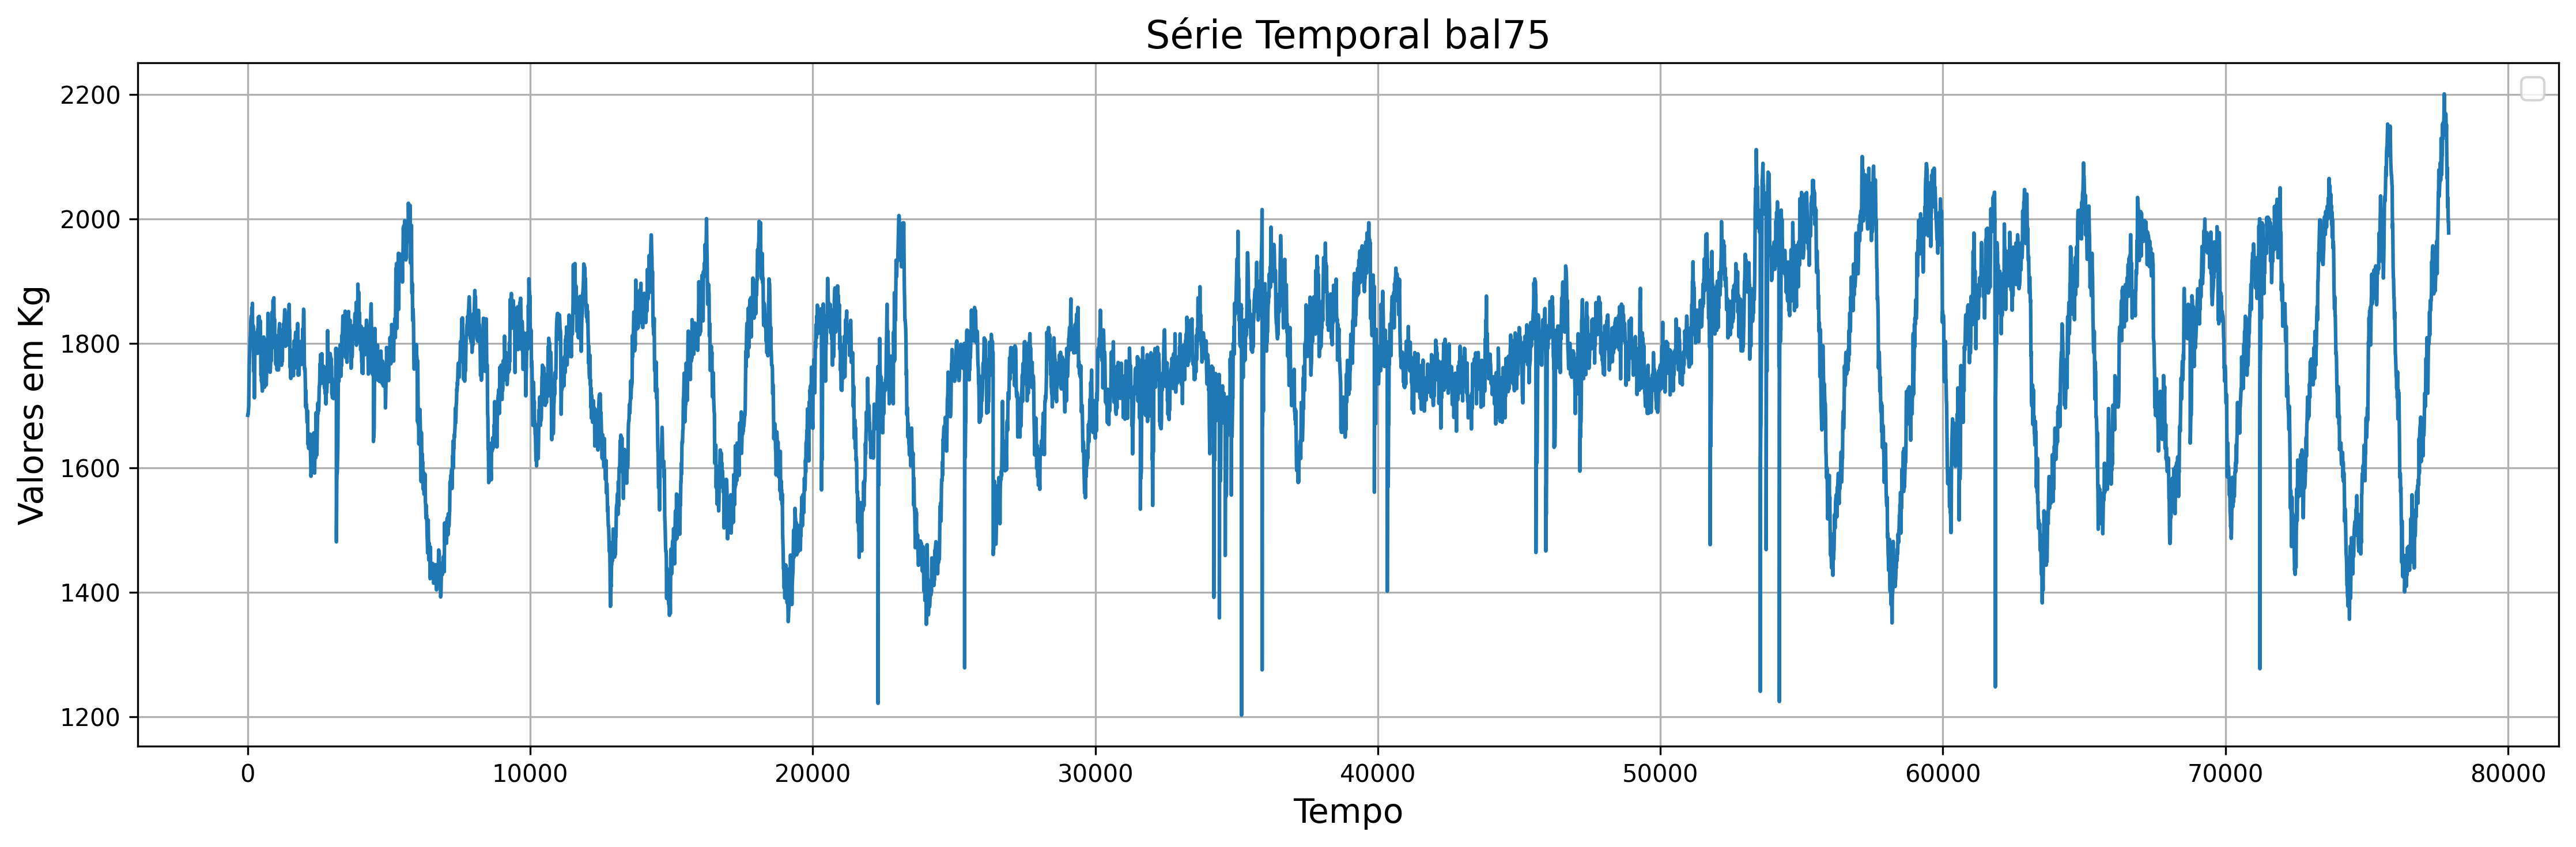

In [4]:
# Filtrar os índices onde os valores são menores que 1200
indices_menores_que_1200 = dt[dt['bal75'] < 1200].index

# Calcular a média da coluna 'bal75'
media_bal75 = dt['bal75'].mean()

# Substituir os valores menores que 1200 pela média
dt.loc[dt['bal75'] < 1200, 'bal75'] = media_bal75

# Verificar se os valores foram substituídos corretamente
print(dt.loc[indices_menores_que_1200, 'bal75'])

# Plotar a Série Temporal que Desejamos Predizer
plt.figure(figsize=(15, 5),  dpi=300)
plt.plot(dt['bal75'])

# Adicionar títulos e legendas
plt.xlabel('Tempo', fontsize=14)
plt.ylabel('Valores em Kg', fontsize=14)
plt.title('Série Temporal bal75', fontsize=16)
plt.legend(fontsize=12)

# Melhorar a legibilidade do gráfico
plt.grid(True)
plt.tight_layout()

# Mostrar o gráfico
plt.show()

In [5]:
y_min = dt['bal75'].min()
y_max = dt['bal75'].max()

print(f"O valor mínimo de 'bal75' é: {y_min}")
print(f"O valor máximo de 'bal75' é: {y_max}")

O valor mínimo de 'bal75' é: 1202.511
O valor máximo de 'bal75' é: 2201.279


In [6]:
# Suponha que 'data' seja seu DataFrame com dados coletados a cada segundo
# Vamos criar algumas features a partir da coluna de interesse 'TCSacr'

# Features estatísticas em janelas de tempo
dt['mean_10s'] = dt['TCSacr'].rolling(window=10).mean()
dt['std_10s'] = dt['TCSacr'].rolling(window=10).std()
dt['min_10s'] = dt['TCSacr'].rolling(window=10).min()
dt['max_10s'] = dt['TCSacr'].rolling(window=10).max()

dt['mean_5s'] = dt['TCSacr'].rolling(window=5).mean()
dt['std_5s'] = dt['TCSacr'].rolling(window=5).std()
dt['min_5s'] = dt['TCSacr'].rolling(window=5).min()
dt['max_5s'] = dt['TCSacr'].rolling(window=5).max()

# Diferenças e Mudanças
dt['diff_1s'] = dt['TCSacr'].diff(periods=1)
dt['diff_5s'] = dt['TCSacr'].diff(periods=5)
dt['diff_10s'] = dt['TCSacr'].diff(periods=10)

# Lags
#data['lag_1s'] = data['TCSacr'].shift(1)
dt['lag_5s'] = dt['TCSacr'].shift(5)
dt['lag_10s'] = dt['TCSacr'].shift(10)
dt['lag_30s'] = dt['TCSacr'].shift(30)
dt['lag_60s'] = dt['TCSacr'].shift(60)

# Normalização
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
dt['TCSacr_scaled'] = scaler.fit_transform(dt[['TCSacr']])


# Exibir o DataFrame com as novas features
print(dt.head())

   med10  sd10  med5  sd5  TCSacr     bal75  mean_10s  std_10s  min_10s  \
0   23.0   0.0  23.0  0.0    23.0  1684.598       NaN      NaN      NaN   
1   23.0   0.0  23.0  0.0    23.0  1684.971       NaN      NaN      NaN   
2   23.0   0.0  23.0  0.0    23.0  1685.343       NaN      NaN      NaN   
3   23.0   0.0  23.0  0.0    23.0  1685.716       NaN      NaN      NaN   
4   23.0   0.0  23.0  0.0    23.0  1686.088       NaN      NaN      NaN   

   max_10s  ...  min_5s  max_5s  diff_1s  diff_5s  diff_10s  lag_5s  lag_10s  \
0      NaN  ...     NaN     NaN      NaN      NaN       NaN     NaN      NaN   
1      NaN  ...     NaN     NaN      0.0      NaN       NaN     NaN      NaN   
2      NaN  ...     NaN     NaN      0.0      NaN       NaN     NaN      NaN   
3      NaN  ...     NaN     NaN      0.0      NaN       NaN     NaN      NaN   
4      NaN  ...    23.0    23.0      0.0      NaN       NaN     NaN      NaN   

   lag_30s  lag_60s  TCSacr_scaled  
0      NaN      NaN      -0.308

In [7]:
dt = dt.drop(['med10', 'sd10', 'med5', 'sd5'], axis=1)
dt = dt.dropna()
dt.head()

TCSacr     bal75   mean_10s   std_10s    min_10s    max_10s    mean_5s  \
60  22.485712  1773.381  22.935352  0.302523  22.485712  23.384993  22.685551   
61  22.385792  1774.599  22.835432  0.302523  22.385792  23.285072  22.585632   
62  22.285872  1775.818  22.735512  0.302523  22.285872  23.185152  22.485712   
63  22.185951  1777.037  22.635592  0.302523  22.185951  23.085232  22.385792   
64  22.086031  1778.256  22.535671  0.302523  22.086031  22.985312  22.285872   

      std_5s     min_5s     max_5s   diff_1s   diff_5s  diff_10s     lag_5s  \
60  0.157987  22.485712  22.885391 -0.099920 -0.499600 -0.999201  22.985312   
61  0.157987  22.385792  22.785471 -0.099920 -0.499599 -0.999201  22.885391   
62  0.157987  22.285872  22.685551 -0.099920 -0.499599 -0.999200  22.785471   
63  0.157988  22.185951  22.585632 -0.099921 -0.499600 -0.999201  22.685551   
64  0.157988  22.086031  22.485712 -0.099920 -0.499601 -0.999201  22.585632   

      lag_10s    lag_30s  lag_60s  TCSacr_scaled  
60  23.484913  23.517487     23.0      -0.764833  
61  23.384993  23.617407     23.0      -0.853480  
62  23.285072  23.717325     23.0      -0.942126  
63  23.185152  23.817245     23.0      -1.030773  
64  23.085232  23.917166     23.0      -1.119419

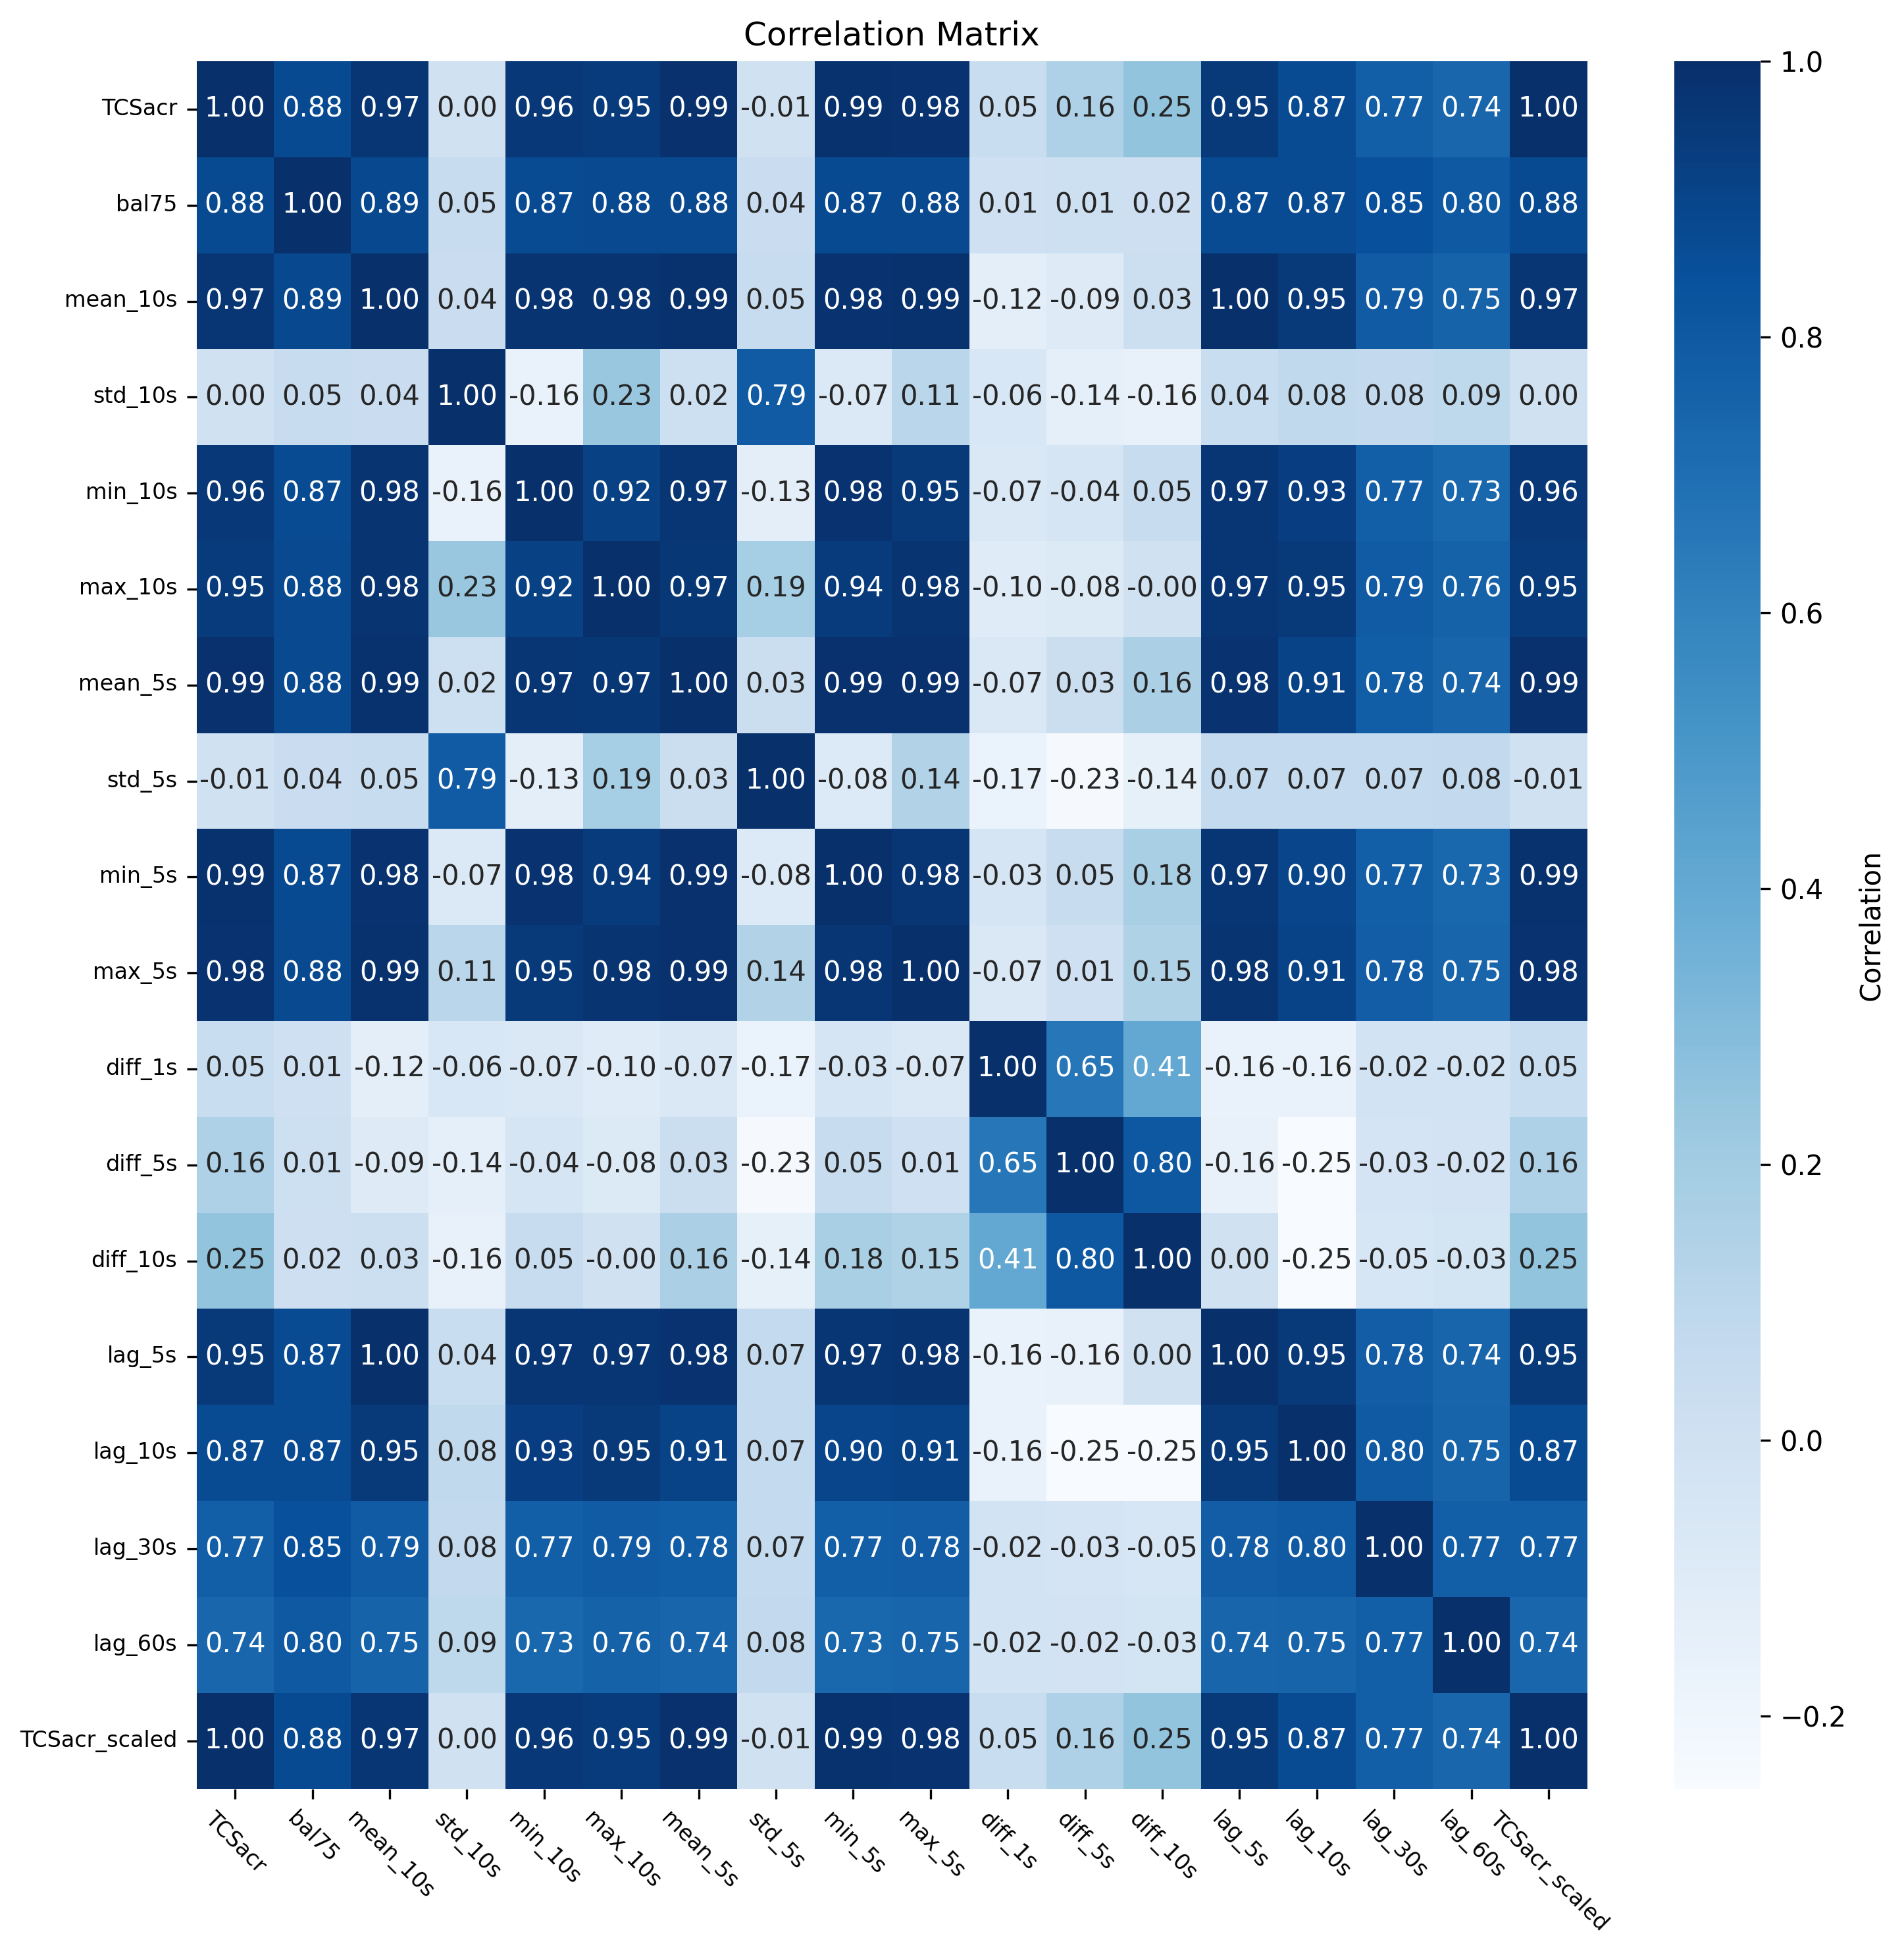

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Supondo que 'data' seja o seu DataFrame
# Calcular a matriz de correlação
correlation_matrix = dt.corr()

# Corrigir a indexação da matriz de correlação para pegar a matriz de tamanho 18x18 (dependendo das colunas que você tem)
corr = correlation_matrix.iloc[:18, :18]  # Selecionar as primeiras 18 colunas e linhas

# Configurando o tamanho da figura
plt.figure(figsize=(10, 10), dpi=300)

# Plotando a matriz de correlação com a escala azul ("Blues")
ax = sns.heatmap(corr, annot=True, fmt=".2f", cmap="Blues", annot_kws={"size": 10}, cbar_kws={'label': 'Correlation'},
                 xticklabels=['TCSacr', 'bal75', 'mean_10s', 'std_10s', 'min_10s', 'max_10s',
                              'mean_5s', 'std_5s', 'min_5s', 'max_5s', 'diff_1s', 'diff_5s',
                              'diff_10s', 'lag_5s', 'lag_10s', 'lag_30s', 'lag_60s', 'TCSacr_scaled'],
                 yticklabels=['TCSacr', 'bal75', 'mean_10s', 'std_10s', 'min_10s', 'max_10s',
                              'mean_5s', 'std_5s', 'min_5s', 'max_5s', 'diff_1s', 'diff_5s',
                              'diff_10s', 'lag_5s', 'lag_10s', 'lag_30s', 'lag_60s', 'TCSacr_scaled'])

# Ajustando o tamanho da fonte dos rótulos
ax.set_xticklabels(ax.get_xticklabels(), rotation=-45, horizontalalignment='center', fontsize=8)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)

# Ajustando o título da matriz
plt.title("Correlation Matrix", fontsize=12)

# Exibindo o gráfico ajustado
plt.tight_layout()
plt.show()

In [9]:
# Supondo que correlation_matrix seja a matriz de correlação já calculada
# Esta matriz tem as correlações entre todas as variáveis

# Definir um limiar para a correlação
threshold = 0.9

# Identificar variáveis com correlação maior ou igual a 0.9 entre si
correlated_features = set()  # Armazenar as colunas que serão removidas

# Loop sobre cada coluna
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) >= threshold:
            column_1 = correlation_matrix.columns[i]
            column_2 = correlation_matrix.columns[j]
            # Comparar qual das duas colunas tem maior correlação com o target 'bal75'
            if abs(correlation_matrix.loc['bal75', column_1]) > abs(correlation_matrix.loc['bal75', column_2]):
                correlated_features.add(column_2)  # Remover coluna com menor correlação com 'bal75'
            else:
                correlated_features.add(column_1)

# Remover as colunas altamente correlacionadas
reduced_data = dt.drop(labels=correlated_features, axis=1)

# Exibir as colunas que foram removidas e o novo conjunto de dados reduzido
correlated_features, reduced_data.columns

reduced_data.head()
data = reduced_data
data.head()

bal75   mean_10s   std_10s    std_5s   diff_1s   diff_5s  diff_10s  \
60  1773.381  22.935352  0.302523  0.157987 -0.099920 -0.499600 -0.999201   
61  1774.599  22.835432  0.302523  0.157987 -0.099920 -0.499599 -0.999201   
62  1775.818  22.735512  0.302523  0.157987 -0.099920 -0.499599 -0.999200   
63  1777.037  22.635592  0.302523  0.157988 -0.099921 -0.499600 -0.999201   
64  1778.256  22.535671  0.302523  0.157988 -0.099920 -0.499601 -0.999201   

      lag_30s  lag_60s  
60  23.517487     23.0  
61  23.617407     23.0  
62  23.717325     23.0  
63  23.817245     23.0  
64  23.917166     23.0

In [10]:
data['bal75_next_1'] = data['bal75'].shift(-1)
data.head()

bal75   mean_10s   std_10s    std_5s   diff_1s   diff_5s  diff_10s  \
60  1773.381  22.935352  0.302523  0.157987 -0.099920 -0.499600 -0.999201   
61  1774.599  22.835432  0.302523  0.157987 -0.099920 -0.499599 -0.999201   
62  1775.818  22.735512  0.302523  0.157987 -0.099920 -0.499599 -0.999200   
63  1777.037  22.635592  0.302523  0.157988 -0.099921 -0.499600 -0.999201   
64  1778.256  22.535671  0.302523  0.157988 -0.099920 -0.499601 -0.999201   

      lag_30s  lag_60s  bal75_next_1  
60  23.517487     23.0      1774.599  
61  23.617407     23.0      1775.818  
62  23.717325     23.0      1777.037  
63  23.817245     23.0      1778.256  
64  23.917166     23.0      1779.474

  File "C:\Users\franc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

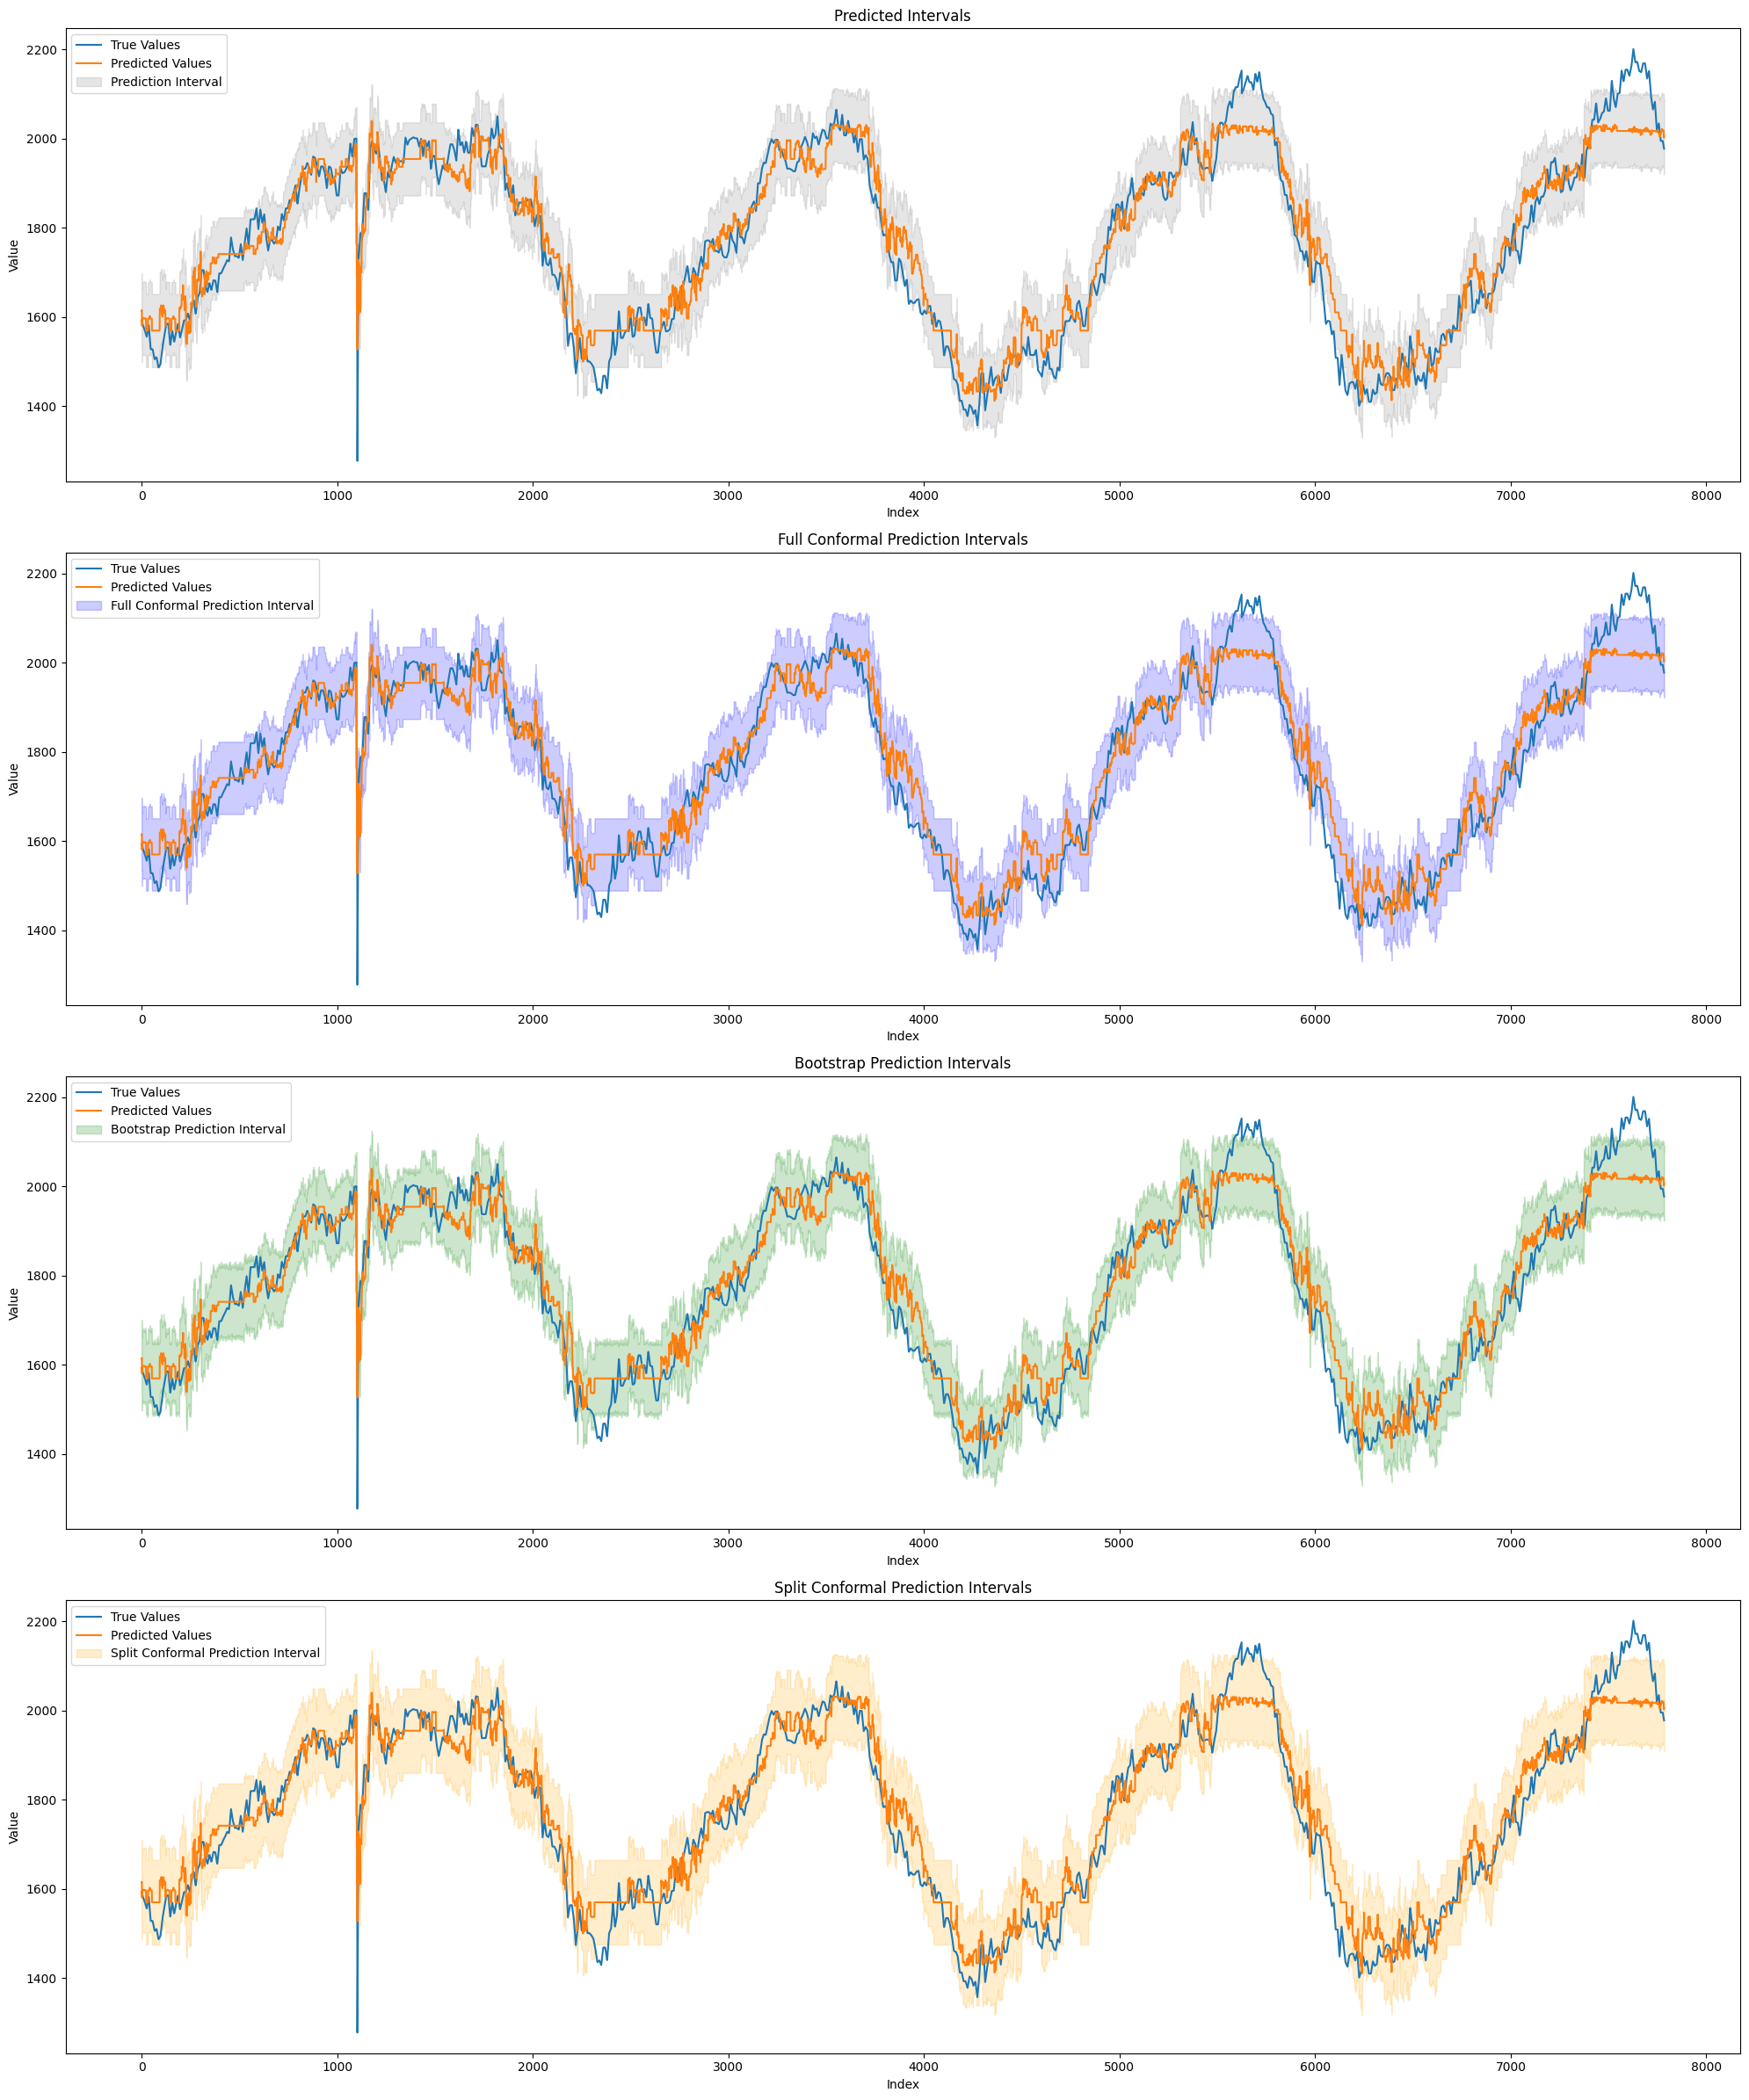

Comparison of Interval Metrics:
Confidence Intervals - Coverage Score: 0.8763005780346821, Mean Width Score: 164.12747027520004, CWC: 507.0956263227578, RMSE: 54.34505651566778
Full Conformal Prediction - Coverage Score: 0.8733461785484907, Mean Width Score: 162.23428990908585, CWC: 511.4115629665281, RMSE: 54.34505651566778
Bootstrap Prediction - Coverage Score: 0.8720616570327553, Mean Width Score: 161.4421396643624, CWC: 513.4066120598467, RMSE: 54.34505651566778
Split Conformal Prediction - Coverage Score: 0.915606936416185, Mean Width Score: 189.41487752559988, CWC: 456.58092461884866, RMSE: 54.34505651566778
       True Values  Predicted Values  Confidence Lower Bound  \
70116     1592.354       1614.487533             1532.423798   
70117     1590.753       1615.635186             1533.571451   
70118     1589.153       1580.489966             1498.426230   
70119     1587.552       1596.449518             1514.385783   
70120     1585.952       1596.682036             1514.6183

In [11]:
# Funções para calcular intervalos de predição
def calculate_prediction_intervals(y_pred, residuals, n, alpha=0.05):
    s_err = np.std(residuals, ddof=1)  # Erro padrão dos resíduos
    p = X_train.shape[1]  # Número de features
    dof = n - p
    t_value = stats.t.ppf(1 - alpha/2, dof)
    margin_of_error = t_value * s_err * np.sqrt(1 + 1/n)
    lower_bound = y_pred - margin_of_error
    upper_bound = y_pred + margin_of_error
    return lower_bound, upper_bound
'''
# Função para calcular intervalos de predição conforme completo (full conformal prediction)
def full_conformal_prediction_intervals(model, X, y, alpha=0.05):
    model.fit(X, y)
    y_pred = model.predict(X)
    residuals = np.abs(y - y_pred)

    n = len(X)
    q_quantile = (n + 1) * (1 - alpha) / n
    quantile = np.quantile(residuals, q_quantile)

    lower_bounds = []
    upper_bounds = []
    for i in range(len(X)):
        X_i = X.iloc[i].values.reshape(1, -1)  # Acessar os valores como numpy array
        y_i = y.iloc[i]

        y_pred_i = model.predict(X_i)
        residual_i = np.abs(y_i - y_pred_i)

        lower_bound = y_pred_i - quantile
        upper_bound = y_pred_i + quantile

        lower_bounds.append(lower_bound)
        upper_bounds.append(upper_bound)

    return np.array(lower_bounds).flatten(), np.array(upper_bounds).flatten()
'''
# Estimativa Intervalar com Full Conformal Prediction
def full_conformal_prediction_intervals(model, X_train, X_test, y_train, alpha=0.05):
    """
    Função para calcular intervalos de predição usando Full Conformal Prediction,
    implementando a fórmula correta para o cálculo do quantil.

    Parâmetros:
    - model: O modelo a ser treinado.
    - X_train: Conjunto de treinamento (features).
    - X_test: Conjunto de teste (features).
    - y_train: Valores alvo do conjunto de treinamento.
    - alpha: Nível de significância (0.05 para intervalo de confiança de 95%).

    Retorna:
    - lower_bound: Limite inferior dos intervalos de predição para o conjunto de teste.
    - upper_bound: Limite superior dos intervalos de predição para o conjunto de teste.
    - quantile: O quantil usado para os cálculos.
    """
    # Treinar o modelo no conjunto de treino
    model.fit(X_train, y_train)

    # Fazer predições no conjunto de treino
    y_pred_train = model.predict(X_train)

    # Calcular os resíduos (erros absolutos) no conjunto de treino
    residuals_train = np.abs(y_train - y_pred_train)

    # Calcular o quantil correto com base em ((n + 1) * (1 - alpha))/n
    n = len(X_train)
    q_quantile = (n + 1) * (1 - alpha) / n  # Fórmula correta para o quantil

    # Calcular o quantil dos resíduos de treino
    quantile = np.quantile(residuals_train, q_quantile)

    # Fazer predições no conjunto de teste
    y_pred_test = model.predict(X_test)

    # Calcular os intervalos de predição para o conjunto de teste
    lower_bound = y_pred_test - quantile
    upper_bound = y_pred_test + quantile

    return lower_bound, upper_bound, quantile
'''
# Função para calcular intervalos de predição usando bootstrap
def bootstrap_prediction_intervals(model, X_test, y_test, n_bootstrap=1000, alpha=0.05):
    # Número de observações no conjunto de teste
    n_obs = len(X_test)

    # Array para armazenar as previsões bootstrap
    bootstrap_predictions = np.zeros((n_bootstrap, n_obs))

    # Resíduos do modelo original
    residuals = y_test - model.predict(X_test)

    # Bootstrap dos resíduos e cálculo das previsões bootstrap
    for i in range(n_bootstrap):
        # Amostragem com reposição dos resíduos
        bootstrap_residuals = resample(residuals)

        # Previsões bootstrap
        bootstrap_predictions[i, :] = model.predict(X_test) + bootstrap_residuals

    # Cálculo dos intervalos de predição
    lower_bound = np.percentile(bootstrap_predictions, 100 * alpha / 2, axis=0)
    upper_bound = np.percentile(bootstrap_predictions, 100 * (1 - alpha / 2), axis=0)

    return lower_bound, upper_bound
'''
# Estimativa Intervalar com Bootstrap
def bootstrap_prediction_intervals(model, X_train, y_train, X_test, n_bootstrap=1000, alpha=0.05):
    # Fazer previsões no conjunto de teste
    y_pred_test = model.predict(X_test)

    # Calcular os resíduos com base nas previsões do conjunto de treino
    residuals = y_train - model.predict(X_train)

    # Inicializar a matriz de predições bootstrap
    n_obs = len(X_test)
    bootstrap_predictions = np.zeros((n_bootstrap, n_obs))

    # Gerar as predições bootstrap
    for i in range(n_bootstrap):
        # Amostrar com substituição dos resíduos de treinamento, ajustando o tamanho
        bootstrap_residuals = resample(residuals, n_samples=n_obs, replace=True)

        # Adicionar os resíduos bootstrap às previsões do conjunto de teste
        bootstrap_predictions[i, :] = y_pred_test + bootstrap_residuals

    # Calcular os intervalos percentuais
    lower_bound = np.percentile(bootstrap_predictions, 100 * alpha / 2, axis=0)
    upper_bound = np.percentile(bootstrap_predictions, 100 * (1 - alpha / 2), axis=0)

    return lower_bound, upper_bound

# Função para calcular intervalos de predição conforme dividido (split conformal prediction)
def conformal_prediction_intervals(model, X_train, y_train, X_cal, y_cal, X_test, alpha=0.05):
    model.fit(X_train, y_train)
    y_pred_cal = model.predict(X_cal)
    # Residuals
    y_cal_error = np.abs(y_cal - y_pred_cal)
    # Calcular o quantil com ajuste da amostra final para garantir a cobertura
    n_cal = len(y_cal)
    q_quantile = (n_cal + 1) * (1 - alpha) / n_cal
    # Calcular q_hat no conjunto de calibração
    quantile = np.quantile(y_cal_error, q_quantile)
    y_pred_test = model.predict(X_test)
    return y_pred_test - quantile, y_pred_test + quantile

# Função para calcular as métricas dos intervalos de predição
def calculate_interval_metrics(y_true, y_pred, lower_bound, upper_bound, alpha=0.05):
    coverage_score = np.mean((y_true >= lower_bound) & (y_true <= upper_bound))
    mean_width_score = np.mean(upper_bound - lower_bound)
    eta = 10
    gamma = 0 if coverage_score >= (1 - alpha) else 1
    cwc = mean_width_score * (1 + gamma * np.exp(-eta * (coverage_score - (1 - alpha))))
    root_mean_squared_error = np.sqrt(mean_squared_error(y_true, y_pred))
    mean_absolute_error_value = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return coverage_score, mean_width_score, cwc, root_mean_squared_error, mean_absolute_error_value, r2

# Remover quaisquer linhas que contenham NaN (resultantes do shift)
data = data.dropna()

# Definir variáveis de entrada
#X = data[['mean_10s', 'diff_1s', 'diff_5s', 'diff_10s', 'std_10s', 'std_5s', 'lag_60s', 'lag_30s']]
X = data[['mean_10s', 'diff_1s', 'diff_10s', 'lag_60s', 'lag_30s']]
# Variável target
y = data['bal75_next_1']

# Determinar os tamanhos dos conjuntos de treino, calibração e teste
n_train = int(len(X) * 0.80)
n_cal = int(len(X) * 0.10)  # 10% do tamanho total

# A última parte dos dados será usada para teste
n_test = len(X) - n_train - n_cal

# Dividir os dados em conjuntos de treino, teste e calibração
X_train, X_cal, X_test = X[:n_train], X[n_train:n_train+n_cal], X[n_train+n_cal:]
y_train, y_cal, y_test = y[:n_train], y[n_train:n_train+n_cal], y[n_train+n_cal:]

'''
# split the datasets into 3 datasets: proper traininig set, calibration and test
# proper training set is used to train the underlying model, calibration set is used by Conformal Prediction
# test set is used to test models
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=7784, shuffle = True, random_state=None)

# we will use 1000 objects for calibration
X_proper_train, X_cal, y_proper_train, y_cal = train_test_split(X_train, y_train, test_size=1000)
'''

# Treinar um modelo LGBMRegressor
#model = LGBMRegressor(random_state=None)
model = LGBMRegressor(num_leaves=31, min_data_in_leaf=20, subsample=0.8, colsample_bytree=0.8, random_state=None, verbose=-1)

'''
# Calcular intervalos de confiança tradicionais
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
residuals = y_train - model.predict(X_train)
conf_lower, conf_upper = calculate_confidence_intervals(y_pred, residuals, n, alpha=0.05)
'''
# Calcular intervalos de predição usando t-Student
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
residuals = y_train - model.predict(X_train)
pred_lower, pred_upper = calculate_prediction_intervals(y_pred, residuals, len(X_test), alpha=0.05)

# Calcular intervalos de predição conforme completo
#full_lower, full_upper = full_conformal_prediction_intervals(model, X_test, y_test, alpha=0.05)
full_lower, full_upper, _ = full_conformal_prediction_intervals(model, X_train, X_test, y_train, alpha=0.05)

# Calcular intervalos de predição usando bootstrap
#boot_lower, boot_upper = bootstrap_prediction_intervals(model, X_test, y_test, n_bootstrap=1000, alpha=0.05)
boot_lower, boot_upper = bootstrap_prediction_intervals(model, X_train, y_train, X_test, n_bootstrap=1000, alpha=0.05)

# Calcular intervalos de predição conforme dividido
split_lower, split_upper = conformal_prediction_intervals(model, X_train, y_train, X_cal, y_cal, X_test, alpha=0.05)

# Calcular as métricas para cada método de intervalo de predição
metrics_pred = calculate_interval_metrics(y_test, y_pred, pred_lower, pred_upper, alpha=0.05)
metrics_full = calculate_interval_metrics(y_test, y_pred, full_lower, full_upper, alpha=0.05)
metrics_bootstrap = calculate_interval_metrics(y_test, y_pred, boot_lower, boot_upper, alpha=0.05)
metrics_split = calculate_interval_metrics(y_test, y_pred, split_lower, split_upper, alpha=0.05)

# Criar uma tabela comparativa
df_comparison = pd.DataFrame({
    'True Values': y_test,
    'Predicted Values': y_pred,
    'Confidence Lower Bound': pred_lower,
    'Confidence Upper Bound': pred_upper,
    'Full Conformal Lower Bound': full_lower,
    'Full Conformal Upper Bound': full_upper,
    'Bootstrap Lower Bound': boot_lower,
    'Bootstrap Upper Bound': boot_upper,
    'Split Conformal Lower Bound': split_lower,
    'Split Conformal Upper Bound': split_upper,
    # Diferenças entre os limites
    'Pred Width': pred_upper - pred_lower,
    'Full Width': full_upper - full_lower,
    'Boot Width': boot_upper - boot_lower,
    'Split Width': split_upper - split_lower

})

# Plotar os valores verdadeiros e os intervalos de predição em gráficos separados
fig, axs = plt.subplots(4, 1, figsize=(20, 24))

# Gráfico para intervalos de confiança tradicionais
axs[0].plot(y_test.values, label='True Values')
axs[0].plot(y_pred, label='Predicted Values')
axs[0].fill_between(np.arange(len(y_test)), pred_lower, pred_upper, color='gray', alpha=0.2, label='Prediction Interval')
axs[0].set_xlabel('Index')
axs[0].set_ylabel('Value')
axs[0].set_title('Predicted Intervals')
axs[0].legend()

# Gráfico para intervalos de predição conforme completo
axs[1].plot(y_test.values, label='True Values')
axs[1].plot(y_pred, label='Predicted Values')
axs[1].fill_between(np.arange(len(y_test)), full_lower, full_upper, color='blue', alpha=0.2, label='Full Conformal Prediction Interval')
axs[1].set_xlabel('Index')
axs[1].set_ylabel('Value')
axs[1].set_title('Full Conformal Prediction Intervals')
axs[1].legend()

# Gráfico para intervalos de bootstrap
axs[2].plot(y_test.values, label='True Values')
axs[2].plot(y_pred, label='Predicted Values')
axs[2].fill_between(np.arange(len(y_test)), boot_lower, boot_upper, color='green', alpha=0.2, label='Bootstrap Prediction Interval')
axs[2].set_xlabel('Index')
axs[2].set_ylabel('Value')
axs[2].set_title('Bootstrap Prediction Intervals')
axs[2].legend()

# Gráfico para intervalos de predição conforme dividido
axs[3].plot(y_test.values, label='True Values')
axs[3].plot(y_pred, label='Predicted Values')
axs[3].fill_between(np.arange(len(y_test)), split_lower, split_upper, color='orange', alpha=0.2, label='Split Conformal Prediction Interval')
axs[3].set_xlabel('Index')
axs[3].set_ylabel('Value')
axs[3].set_title('Split Conformal Prediction Intervals')
axs[3].legend()

plt.tight_layout()
plt.show()

# Exibir a tabela comparativa
print("Comparison of Interval Metrics:")
print(f"Confidence Intervals - Coverage Score: {metrics_pred[0]}, Mean Width Score: {metrics_pred[1]}, CWC: {metrics_pred[2]}, RMSE: {metrics_pred[3]}")
print(f"Full Conformal Prediction - Coverage Score: {metrics_full[0]}, Mean Width Score: {metrics_full[1]}, CWC: {metrics_full[2]}, RMSE: {metrics_full[3]}")
print(f"Bootstrap Prediction - Coverage Score: {metrics_bootstrap[0]}, Mean Width Score: {metrics_bootstrap[1]}, CWC: {metrics_bootstrap[2]}, RMSE: {metrics_bootstrap[3]}")
print(f"Split Conformal Prediction - Coverage Score: {metrics_split[0]}, Mean Width Score: {metrics_split[1]}, CWC: {metrics_split[2]}, RMSE: {metrics_split[3]}")

# Exibir as primeiras 10 linhas da tabela comparativa
print(df_comparison.head(10))

# Salvar a tabela comparativa em um arquivo CSV
df_comparison.to_csv('prediction_intervals_comparison.csv', index=False)

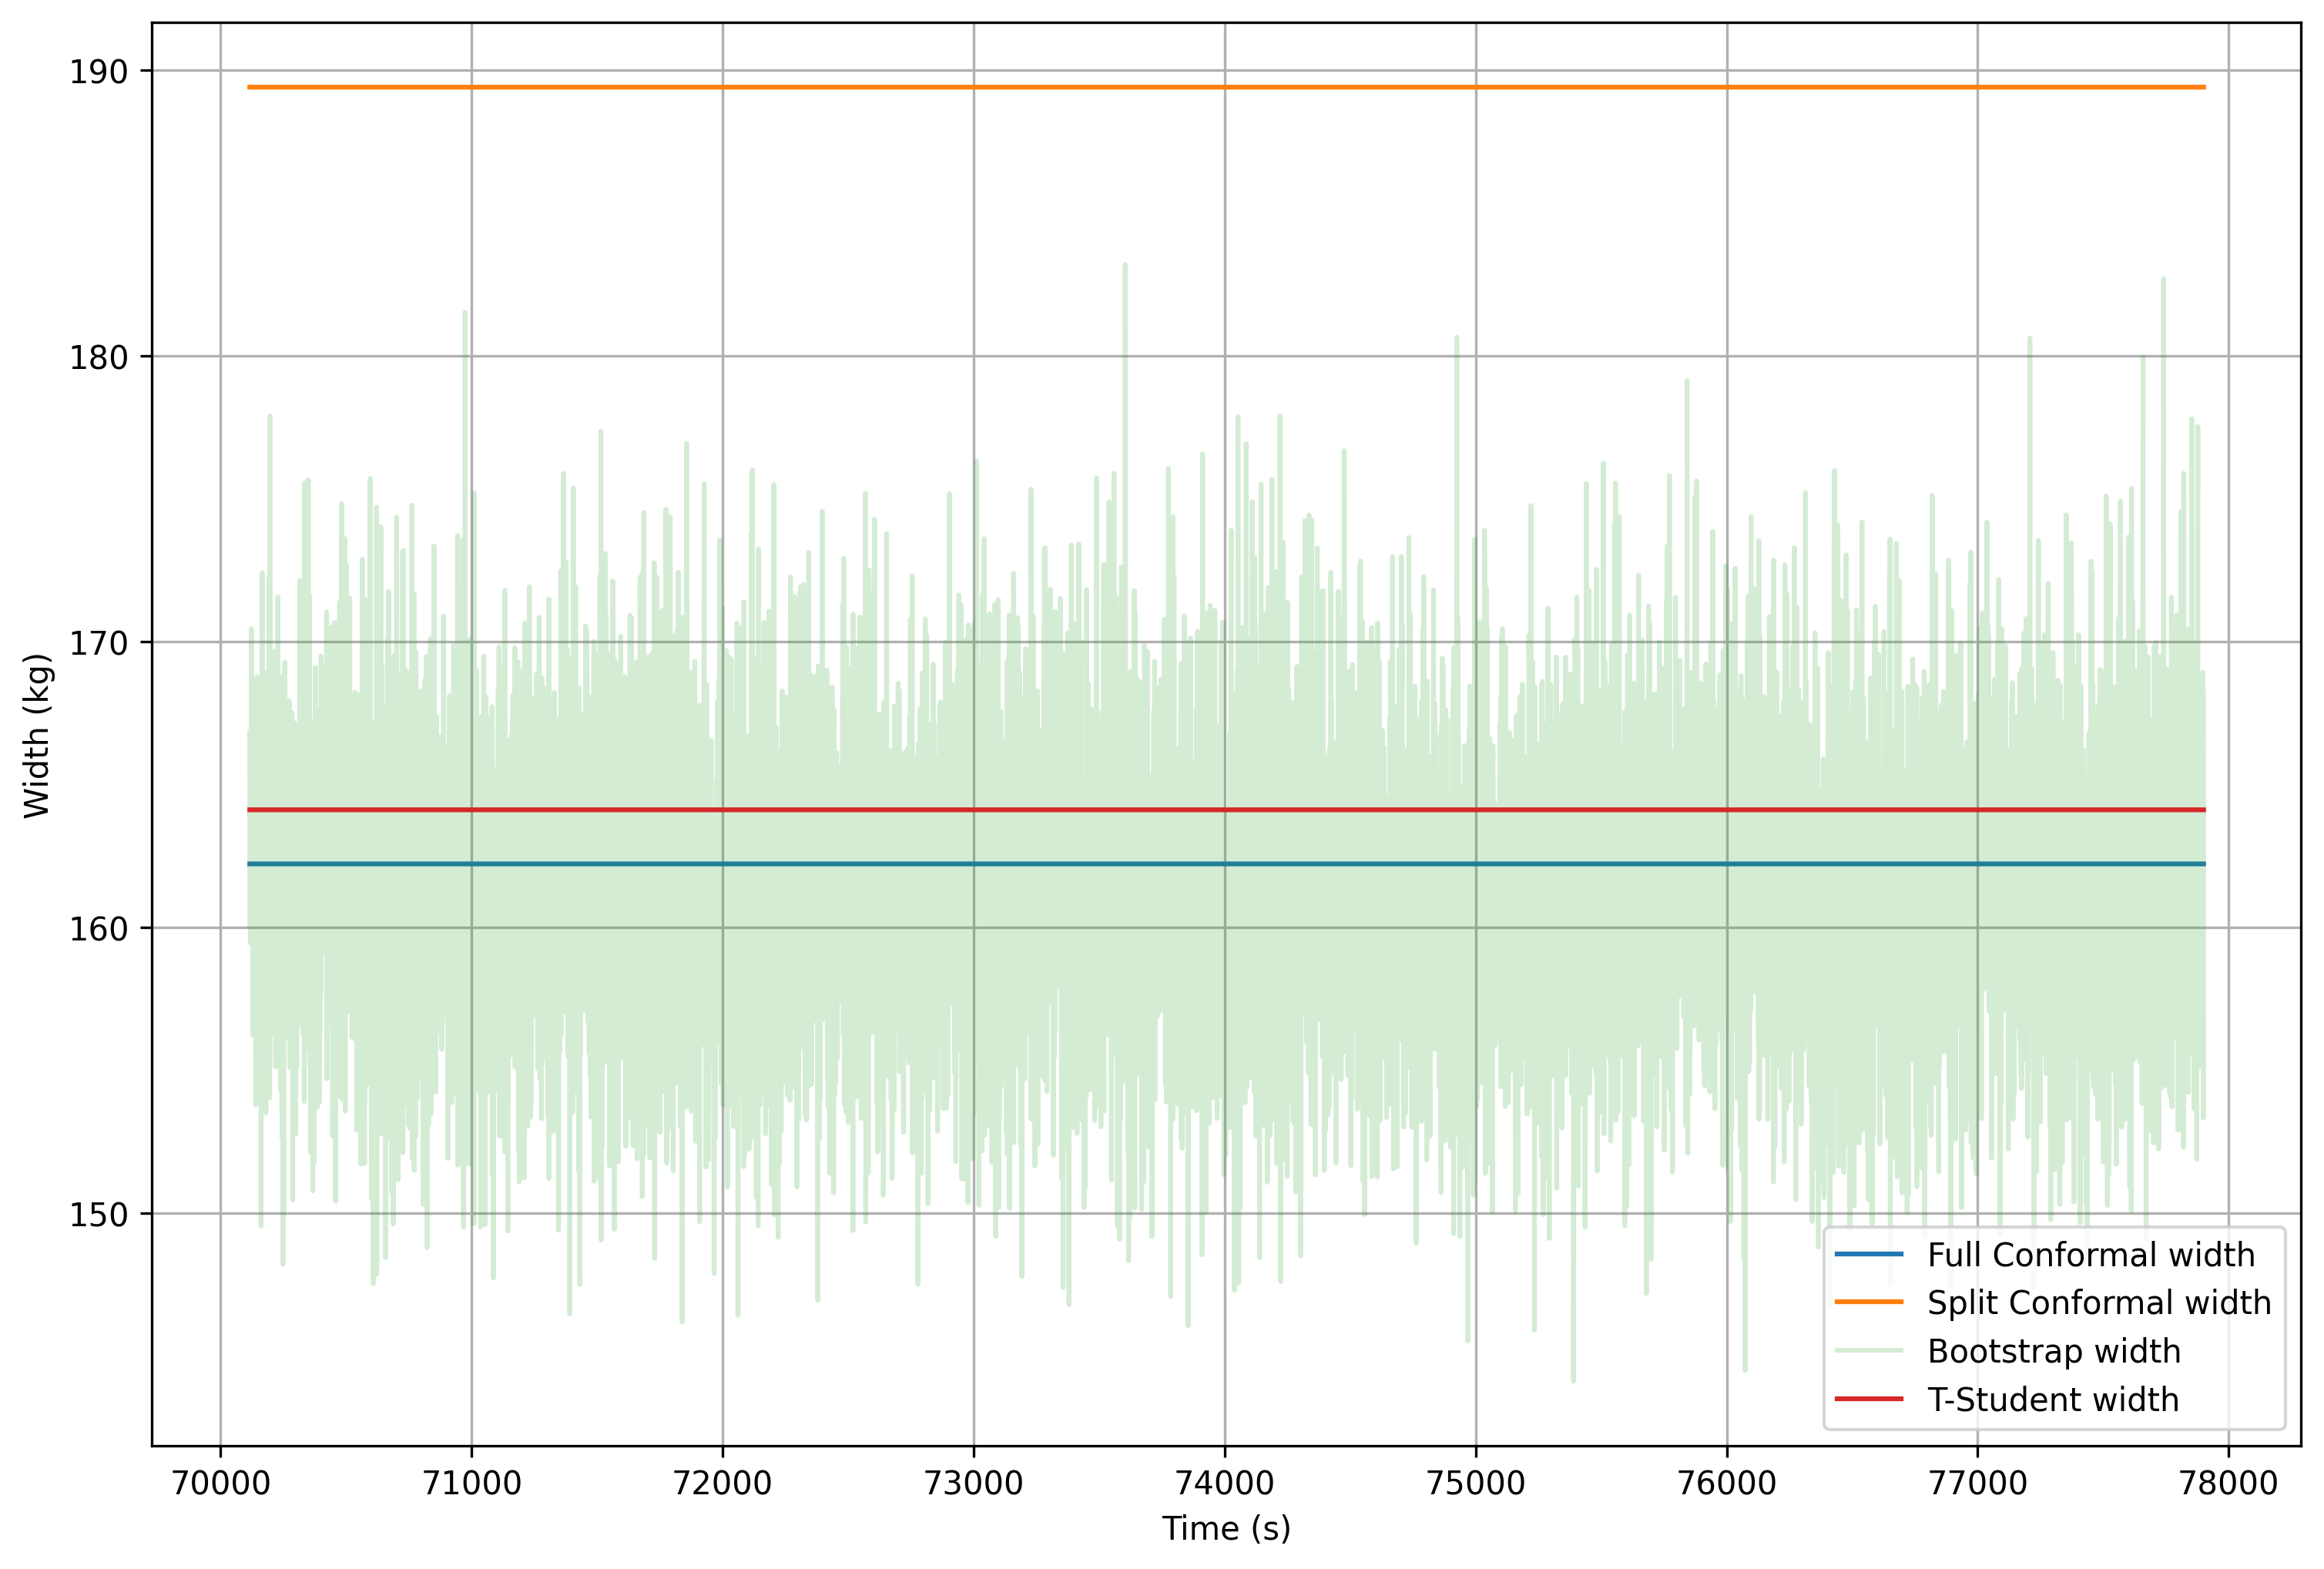

In [12]:
import matplotlib.pyplot as plt

# Plotando as diferenças entre os limites superiores e inferiores de cada método
plt.figure(figsize=(12, 8), dpi=300)

# Plot de cada coluna de diferença
plt.plot(df_comparison.index, df_comparison['Full Width'], label='Full Conformal width')
plt.plot(df_comparison.index, df_comparison['Split Width'], label='Split Conformal width')
plt.plot(df_comparison.index, df_comparison['Boot Width'], label='Bootstrap width', alpha = 0.2)
plt.plot(df_comparison.index, df_comparison['Pred Width'], label='T-Student width')

# Personalização do gráfico
plt.xlabel('Time (s)')
plt.ylabel('Width (kg)')
#plt.title('Variation of interval width over time for each type of prediction interval without using the rolling window')
plt.legend()
plt.grid(True)
plt.show()

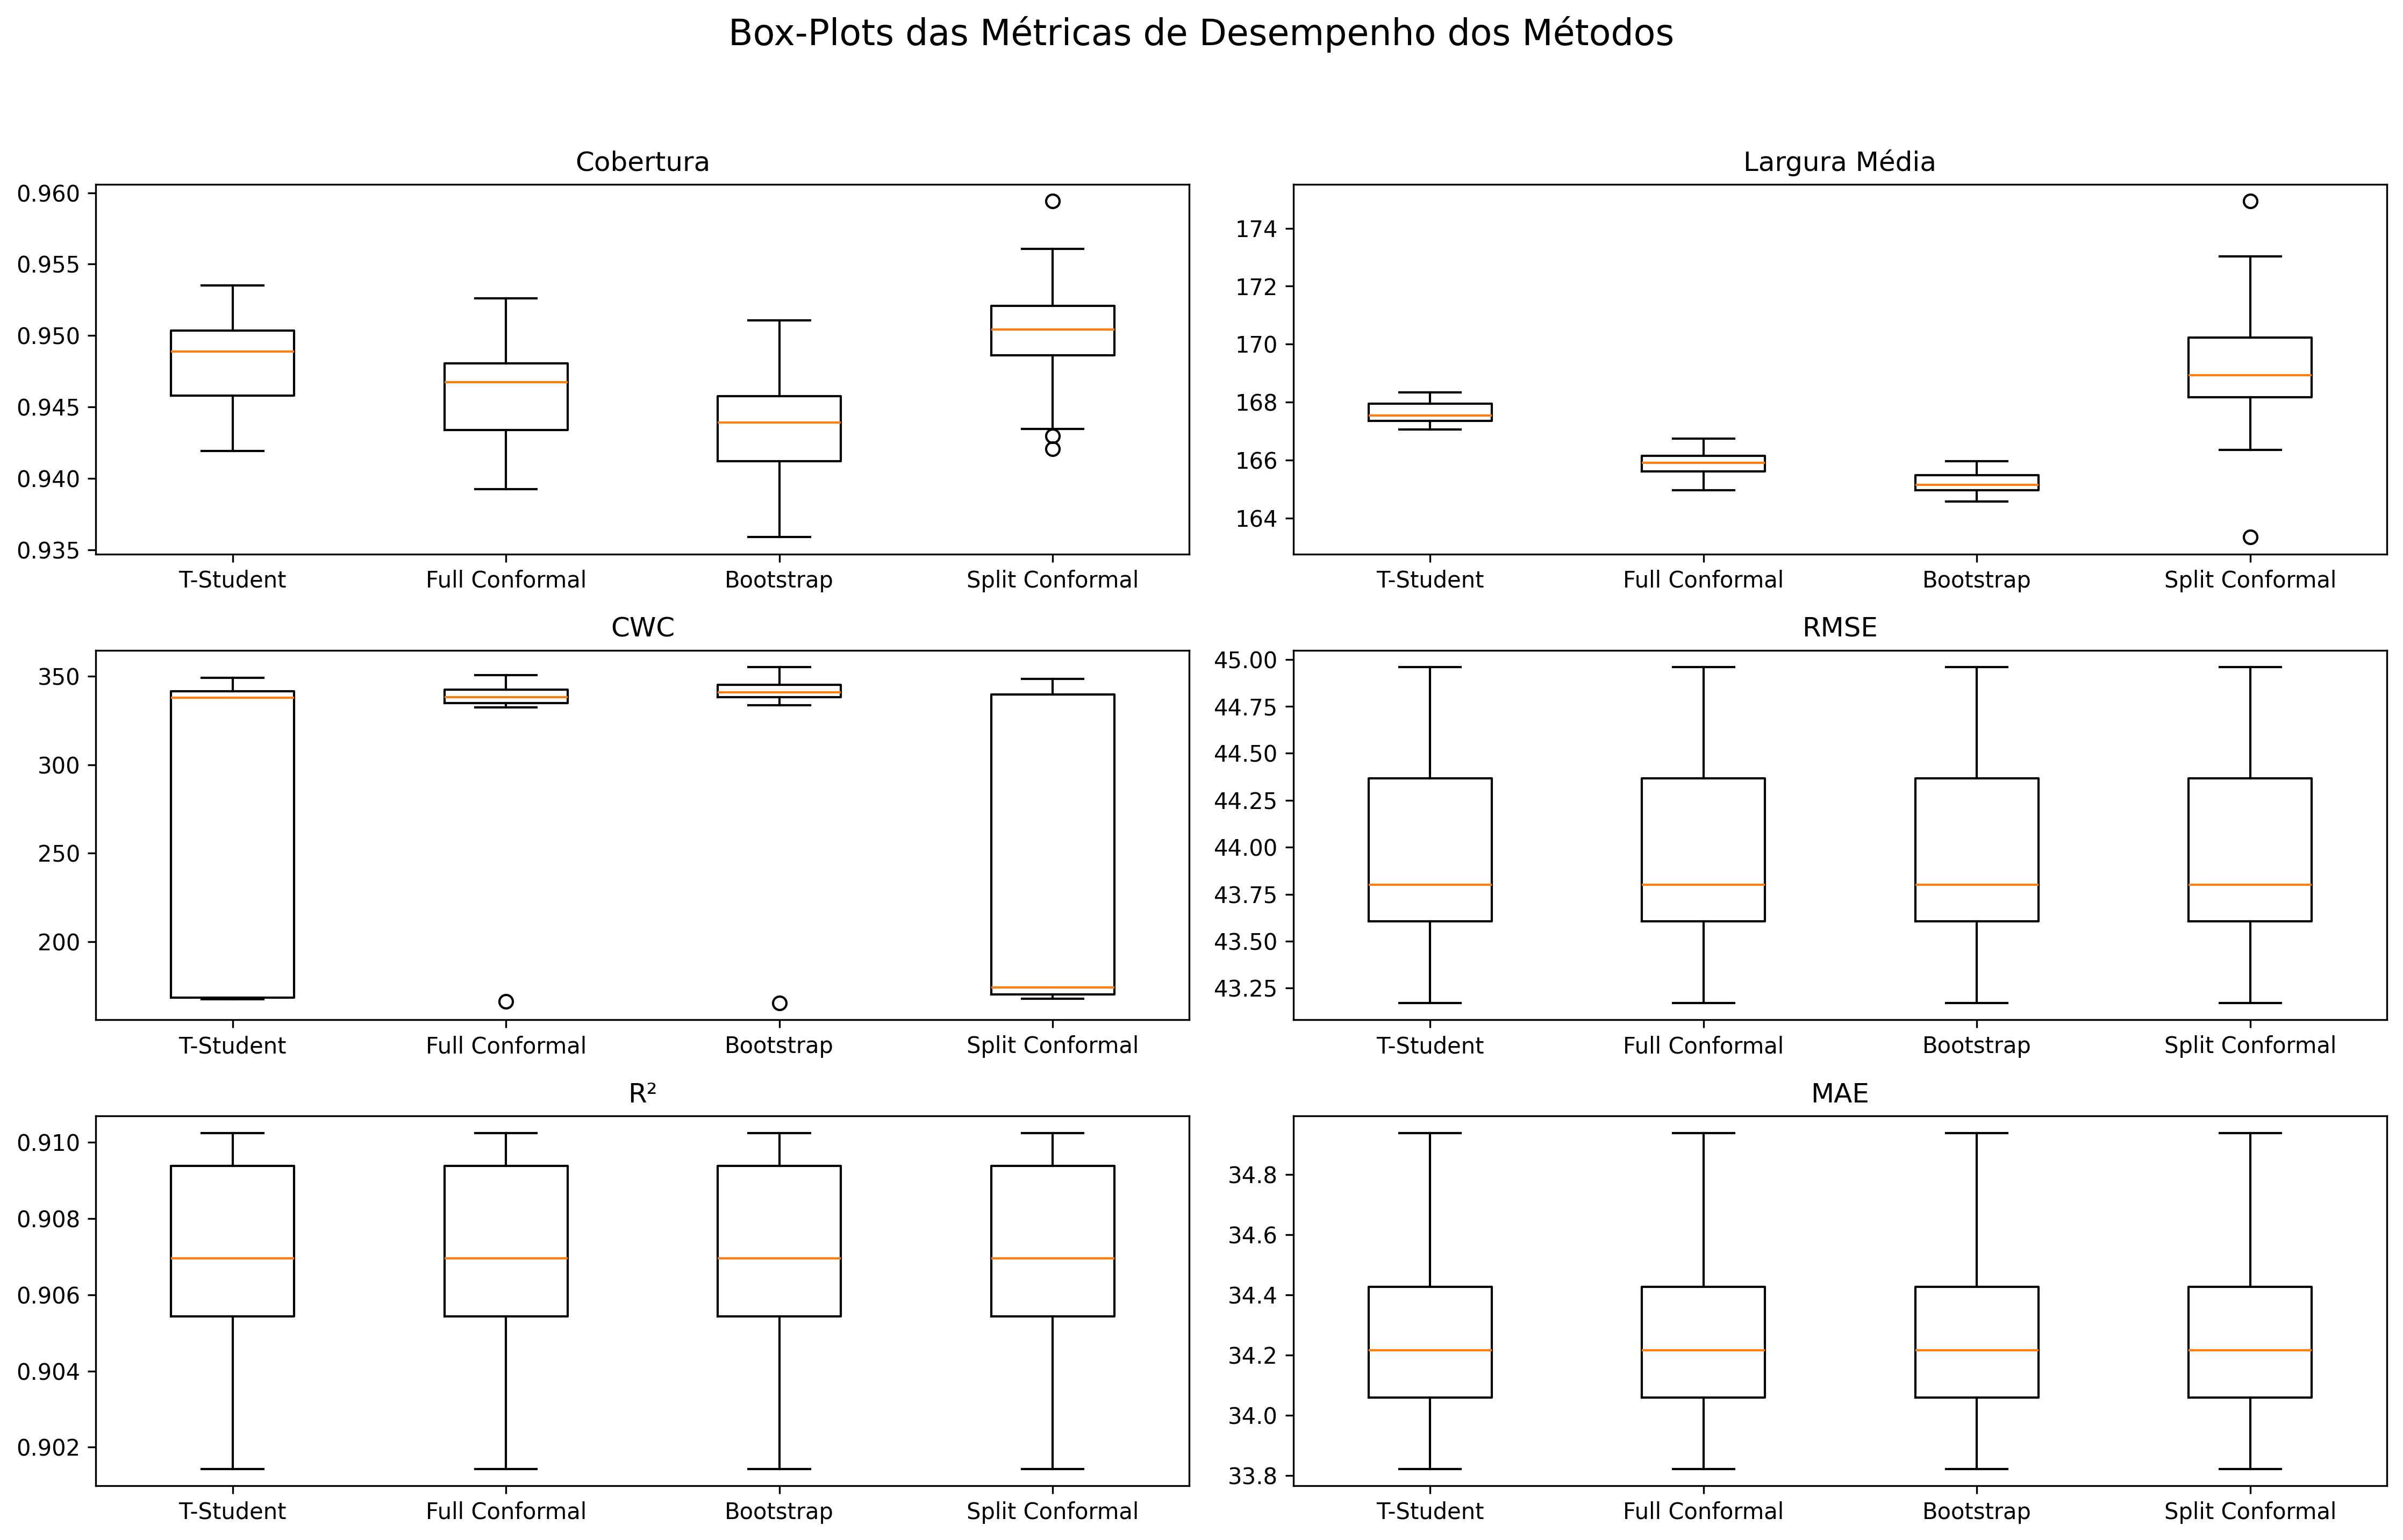

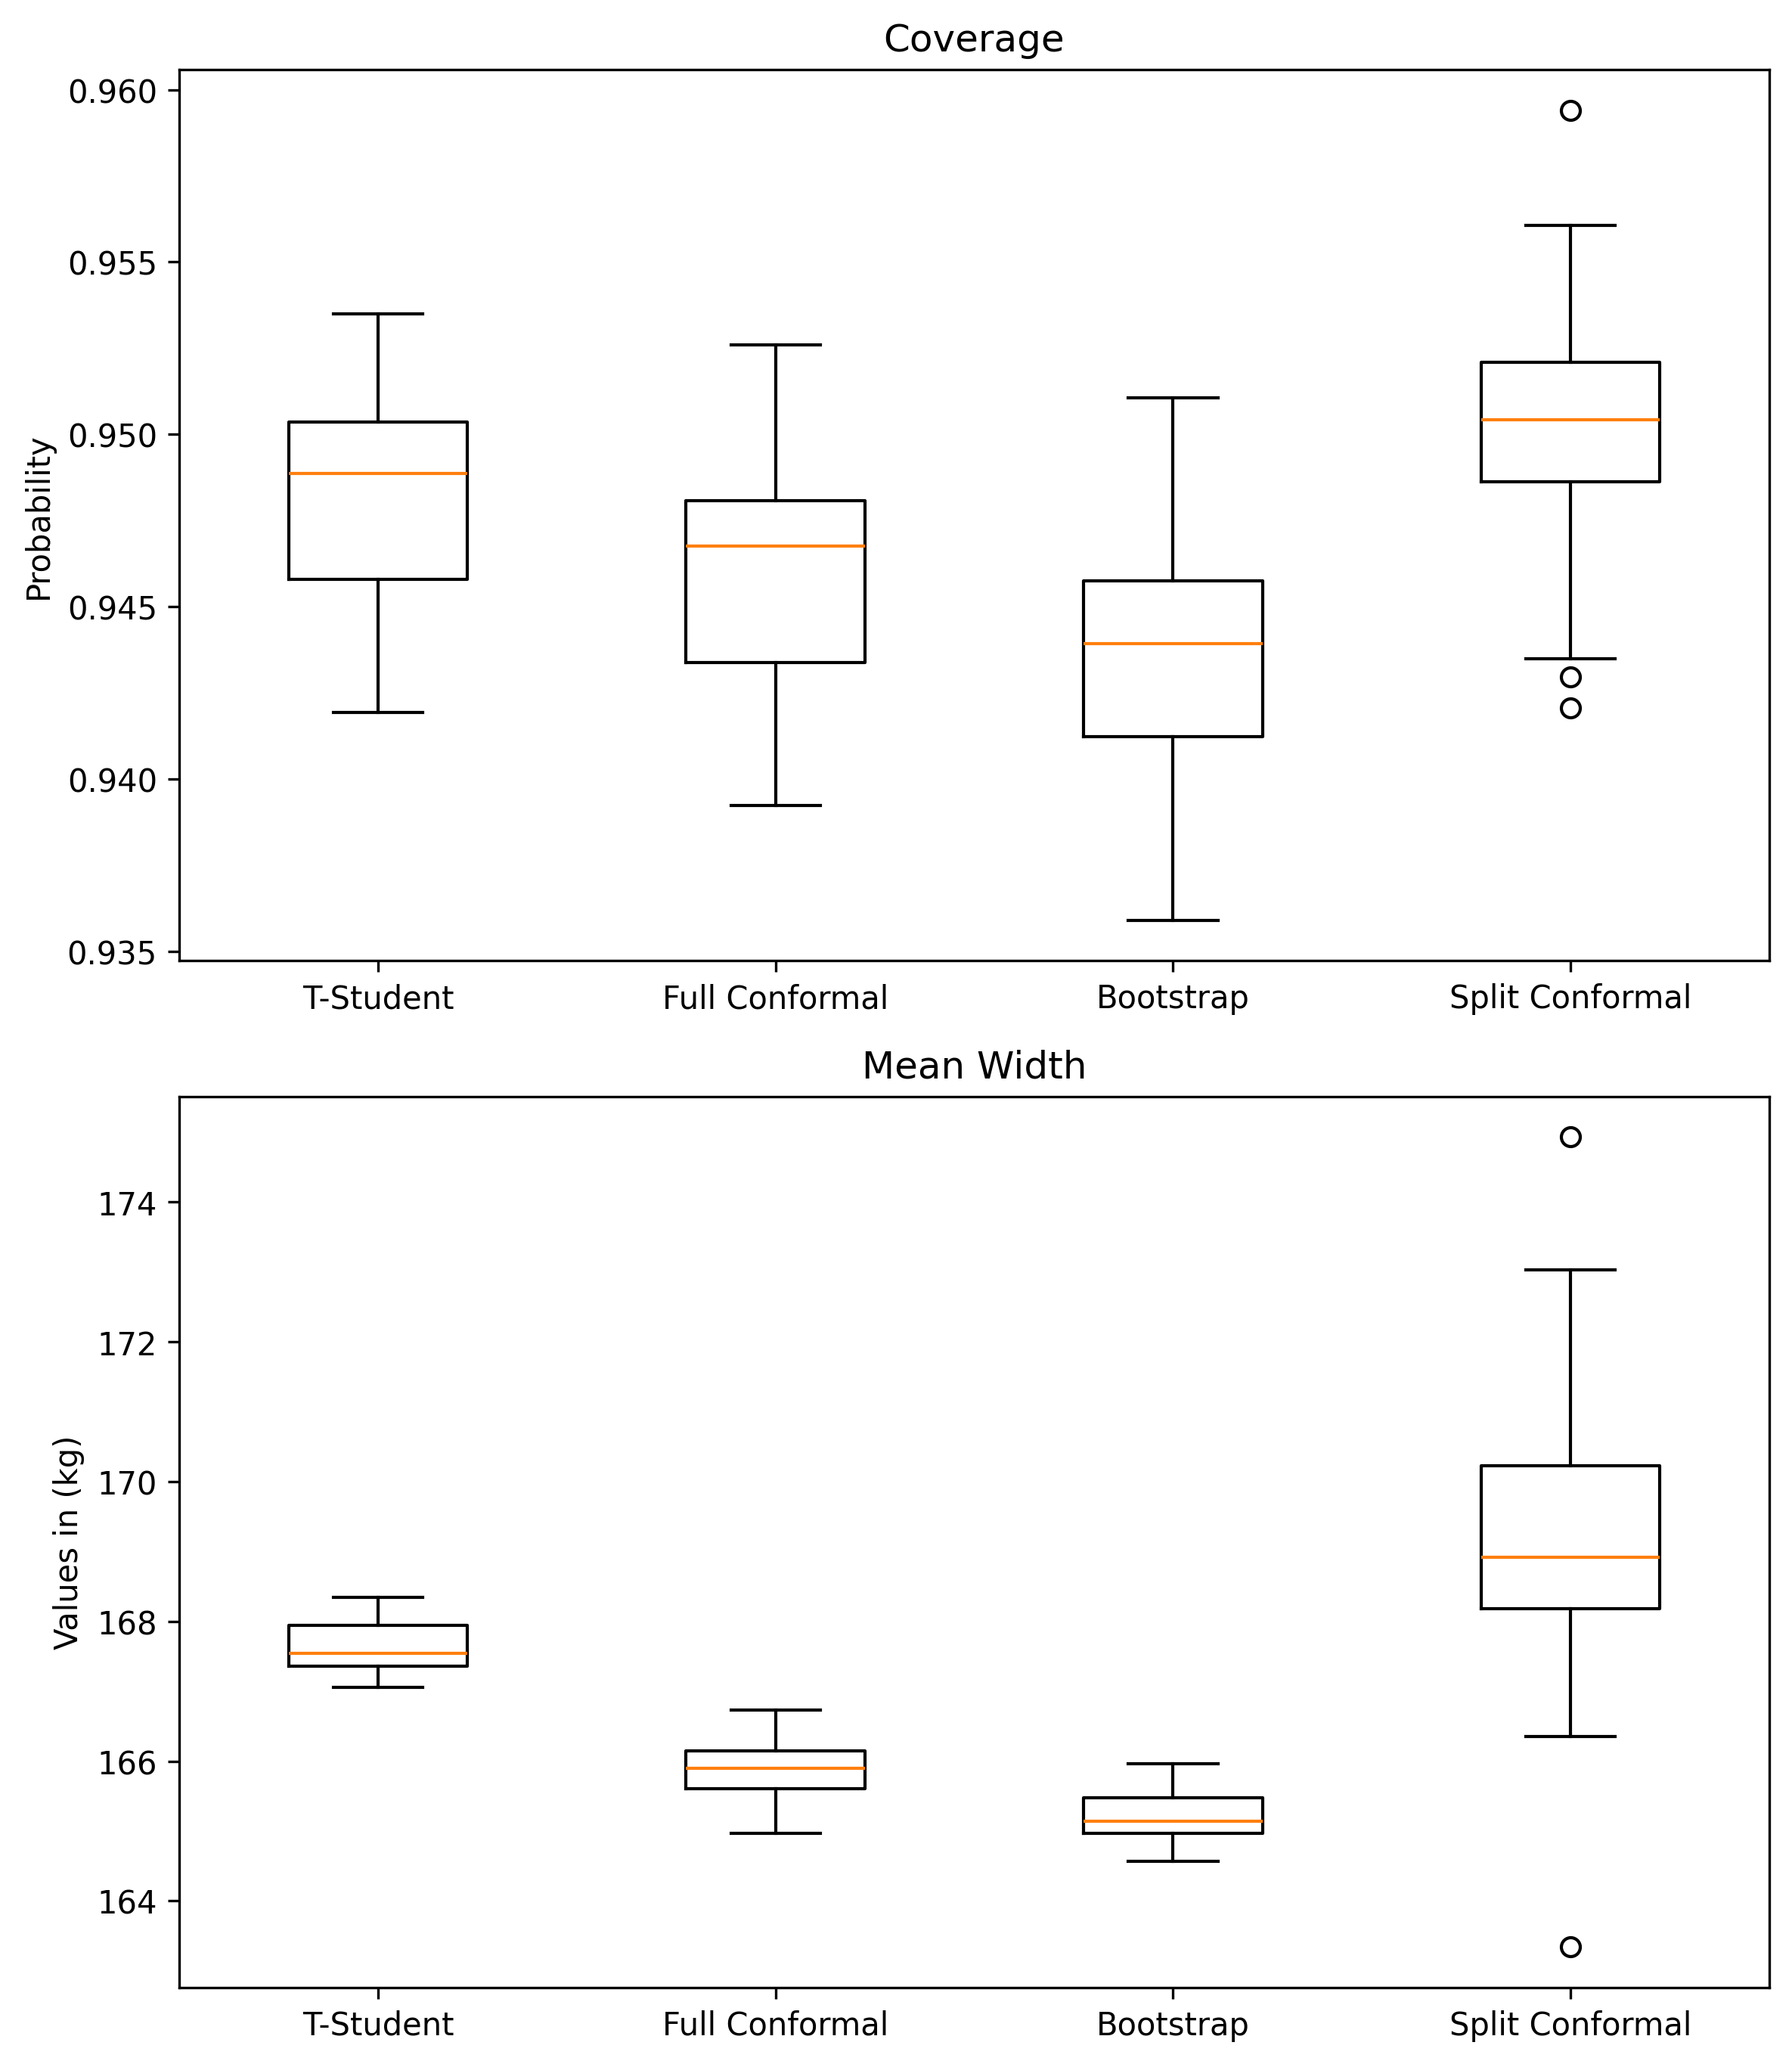

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.utils import resample
from lightgbm import LGBMRegressor
from scipy import stats

# Funções de cálculo de intervalos de predição e métricas de avaliação

def calculate_prediction_intervals(y_pred, residuals, n, p, alpha=0.05):
    s_err = np.std(residuals, ddof=1)  # Erro padrão dos resíduos
    dof = n - p
    t_value = stats.t.ppf(1 - alpha/2, dof)
    margin_of_error = t_value * s_err * np.sqrt(1 + 1/n)
    lower_bound = y_pred - margin_of_error
    upper_bound = y_pred + margin_of_error
    return lower_bound, upper_bound

# Estimativa Intervalar com Full Conformal Prediction
def full_conformal_prediction_intervals(model, X_train, X_test, y_train, alpha=0.05):
    """
    Função para calcular intervalos de predição usando Full Conformal Prediction,
    implementando a fórmula correta para o cálculo do quantil.

    Parâmetros:
    - model: O modelo a ser treinado.
    - X_train: Conjunto de treinamento (features).
    - X_test: Conjunto de teste (features).
    - y_train: Valores alvo do conjunto de treinamento.
    - alpha: Nível de significância (0.05 para intervalo de confiança de 95%).

    Retorna:
    - lower_bound: Limite inferior dos intervalos de predição para o conjunto de teste.
    - upper_bound: Limite superior dos intervalos de predição para o conjunto de teste.
    - quantile: O quantil usado para os cálculos.
    """
    # Treinar o modelo no conjunto de treino
    model.fit(X_train, y_train)

    # Fazer predições no conjunto de treino
    y_pred_train = model.predict(X_train)

    # Calcular os resíduos (erros absolutos) no conjunto de treino
    residuals_train = np.abs(y_train - y_pred_train)

    # Calcular o quantil correto com base em ((n + 1) * (1 - alpha))/n
    n = len(X_train)
    q_quantile = (n + 1) * (1 - alpha) / n  # Fórmula correta para o quantil

    # Calcular o quantil dos resíduos de treino
    quantile = np.quantile(residuals_train, q_quantile)

    # Fazer predições no conjunto de teste
    y_pred_test = model.predict(X_test)

    # Calcular os intervalos de predição para o conjunto de teste
    lower_bound = y_pred_test - quantile
    upper_bound = y_pred_test + quantile

    return lower_bound, upper_bound, quantile
'''
# Função para calcular intervalos de predição usando bootstrap
def bootstrap_prediction_intervals(model, X_test, y_test, n_bootstrap=1000, alpha=0.05):
    # Número de observações no conjunto de teste
    n_obs = len(X_test)

    # Array para armazenar as previsões bootstrap
    bootstrap_predictions = np.zeros((n_bootstrap, n_obs))

    # Resíduos do modelo original
    residuals = y_test - model.predict(X_test)

    # Bootstrap dos resíduos e cálculo das previsões bootstrap
    for i in range(n_bootstrap):
        # Amostragem com reposição dos resíduos
        bootstrap_residuals = resample(residuals)

        # Previsões bootstrap
        bootstrap_predictions[i, :] = model.predict(X_test) + bootstrap_residuals

    # Cálculo dos intervalos de predição
    lower_bound = np.percentile(bootstrap_predictions, 100 * alpha / 2, axis=0)
    upper_bound = np.percentile(bootstrap_predictions, 100 * (1 - alpha / 2), axis=0)

    return lower_bound, upper_bound
'''
# Estimativa Intervalar com Bootstrap
def bootstrap_prediction_intervals(model, X_train, y_train, X_test, n_bootstrap=1000, alpha=0.05):
    # Fazer previsões no conjunto de teste
    y_pred_test = model.predict(X_test)

    # Calcular os resíduos com base nas previsões do conjunto de treino
    residuals = y_train - model.predict(X_train)

    # Inicializar a matriz de predições bootstrap
    n_obs = len(X_test)
    bootstrap_predictions = np.zeros((n_bootstrap, n_obs))

    # Gerar as predições bootstrap
    for i in range(n_bootstrap):
        # Amostrar com substituição dos resíduos de treinamento, ajustando o tamanho
        bootstrap_residuals = resample(residuals, n_samples=n_obs, replace=True)

        # Adicionar os resíduos bootstrap às previsões do conjunto de teste
        bootstrap_predictions[i, :] = y_pred_test + bootstrap_residuals

    # Calcular os intervalos percentuais
    lower_bound = np.percentile(bootstrap_predictions, 100 * alpha / 2, axis=0)
    upper_bound = np.percentile(bootstrap_predictions, 100 * (1 - alpha / 2), axis=0)

    return lower_bound, upper_bound

# Função para calcular intervalos de predição conforme dividido (split conformal prediction)
def conformal_prediction_intervals(model, X_train, y_train, X_cal, y_cal, X_test, alpha=0.05):
    model.fit(X_train, y_train)
    y_pred_cal = model.predict(X_cal)
    # Residuals
    y_cal_error = np.abs(y_cal - y_pred_cal)
    # Calcular o quantil com ajuste da amostra final para garantir a cobertura
    n_cal = len(y_cal)
    q_quantile = (n_cal + 1) * (1 - alpha) / n_cal
    # Calcular q_hat no conjunto de calibração
    quantile = np.quantile(y_cal_error, q_quantile)
    y_pred_test = model.predict(X_test)
    return y_pred_test - quantile, y_pred_test + quantile


def calculate_interval_metrics(y_true, y_pred, lower_bound, upper_bound, alpha=0.05):
    coverage_score = np.mean((y_true >= lower_bound) & (y_true <= upper_bound))
    mean_width_score = np.mean(upper_bound - lower_bound)
    eta = 10
    gamma = 0 if coverage_score >= (1 - alpha) else 1
    cwc = mean_width_score * (1 + gamma * np.exp(-eta * (coverage_score - (1 - alpha))))
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    return coverage_score, mean_width_score, cwc, rmse, r2, mae

# Inicializar listas para armazenar resultados de 30 iterações
metrics_results = {
    'T-Student': {'Coverage': [], 'Mean Width': [], 'CWC': [], 'RMSE': [], 'R2': [], 'MAE':[]},
    'Full Conformal': {'Coverage': [], 'Mean Width': [], 'CWC': [], 'RMSE': [], 'R2': [], 'MAE':[]},
    'Bootstrap': {'Coverage': [], 'Mean Width': [], 'CWC': [], 'RMSE': [], 'R2': [], 'MAE':[]},
    'Split Conformal': {'Coverage': [], 'Mean Width': [], 'CWC': [], 'RMSE': [], 'R2': [], 'MAE':[]}
}

# Definir variáveis de entrada (exemplo com dados fictícios; substitua por seus dados)
#X = data[['mean_10s', 'diff_1s', 'diff_5s', 'diff_10s', 'std_10s', 'std_5s', 'lag_60s', 'lag_30s']]
X = data[['mean_10s', 'diff_1s', 'diff_10s', 'lag_60s', 'lag_30s']]
y = data['bal75_next_1']

from sklearn.model_selection import train_test_split

# Definir proporções para divisão dos dados
train_ratio = 0.8
cal_ratio = 0.1
test_ratio = 0.1

# Realizar 30 iterações para coletar as métricas
for _ in range(30):
    # Dividir em conjunto de treino e conjunto auxiliar (que será dividido em calibração e teste)
    X_train, X_aux, y_train, y_aux = train_test_split(X, y, test_size=(1 - train_ratio), random_state=None)
    
    # Dividir o conjunto auxiliar em calibração e teste
    X_cal, X_test, y_cal, y_test = train_test_split(X_aux, y_aux, test_size=test_ratio/(test_ratio + cal_ratio), random_state=None)
    
    # Treinar o modelo
    model = LGBMRegressor(num_leaves=31, min_data_in_leaf=20, subsample=0.8, colsample_bytree=0.8, random_state=None, verbose=-1)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    residuals = y_train - model.predict(X_train)

    # Cálculo dos intervalos e métricas de cada método (T-Student, Full Conformal, Bootstrap, Split Conformal)
    # T-Student
    lower_bound, upper_bound = calculate_prediction_intervals(y_pred, residuals, len(X_train), X_train.shape[1])
    coverage, mean_width, cwc, rmse, r2, mae = calculate_interval_metrics(y_test, y_pred, lower_bound, upper_bound)
    for metric_name, metric_value in zip(['Coverage', 'Mean Width', 'CWC', 'RMSE', 'R2', 'MAE'],
                                         [coverage, mean_width, cwc, rmse, r2, mae]):
        metrics_results['T-Student'][metric_name].append(metric_value)

    # Full Conformal
    lower_bound, upper_bound, _ = full_conformal_prediction_intervals(model, X_train, X_test, y_train)
    coverage, mean_width, cwc, rmse, r2, mae = calculate_interval_metrics(y_test, y_pred, lower_bound, upper_bound)
    for metric_name, metric_value in zip(['Coverage', 'Mean Width', 'CWC', 'RMSE', 'R2', 'MAE'],
                                         [coverage, mean_width, cwc, rmse, r2, mae]):
        metrics_results['Full Conformal'][metric_name].append(metric_value)

    # Bootstrap
    lower_bound, upper_bound = bootstrap_prediction_intervals(model, X_train, y_train, X_test)
    coverage, mean_width, cwc, rmse, r2, mae = calculate_interval_metrics(y_test, y_pred, lower_bound, upper_bound)
    for metric_name, metric_value in zip(['Coverage', 'Mean Width', 'CWC', 'RMSE', 'R2', 'MAE'],
                                         [coverage, mean_width, cwc, rmse, r2, mae]):
        metrics_results['Bootstrap'][metric_name].append(metric_value)

    # Split Conformal
    lower_bound, upper_bound = conformal_prediction_intervals(model, X_train, y_train, X_cal, y_cal, X_test)
    coverage, mean_width, cwc, rmse, r2, mae = calculate_interval_metrics(y_test, y_pred, lower_bound, upper_bound)
    for metric_name, metric_value in zip(['Coverage', 'Mean Width', 'CWC', 'RMSE', 'R2', 'MAE'],
                                         [coverage, mean_width, cwc, rmse, r2, mae]):
        metrics_results['Split Conformal'][metric_name].append(metric_value)

'''
# Realizar 30 iterações para coletar as métricas
for _ in range(30):
    X_train, X_cal, X_test = X[:n_train], X[n_train:n_train+n_cal], X[n_train+n_cal:]
    y_train, y_cal, y_test = y[:n_train], y[n_train:n_train+n_cal], y[n_train+n_cal:]

    #model = LGBMRegressor(random_state=None)
    model = LGBMRegressor(num_leaves=31, min_data_in_leaf=20, subsample=0.8, colsample_bytree=0.8, random_state=None, verbose=-1)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    residuals = y_train - model.predict(X_train)

    # T-Student
    lower_bound, upper_bound = calculate_prediction_intervals(y_pred, residuals, len(X_train), X_train.shape[1])
    coverage, mean_width, cwc, rmse, r2, mae = calculate_interval_metrics(y_test, y_pred, lower_bound, upper_bound)
    metrics_results['T-Student']['Coverage'].append(coverage)
    metrics_results['T-Student']['Mean Width'].append(mean_width)
    metrics_results['T-Student']['CWC'].append(cwc)
    metrics_results['T-Student']['RMSE'].append(rmse)
    metrics_results['T-Student']['R2'].append(r2)
    metrics_results['T-Student']['MAE'].append(mae)

    # Full Conformal
    lower_bound, upper_bound, _ = full_conformal_prediction_intervals(model, X_train, X_test, y_train)
    coverage, mean_width, cwc, rmse, r2, mae = calculate_interval_metrics(y_test, y_pred, lower_bound, upper_bound)
    metrics_results['Full Conformal']['Coverage'].append(coverage)
    metrics_results['Full Conformal']['Mean Width'].append(mean_width)
    metrics_results['Full Conformal']['CWC'].append(cwc)
    metrics_results['Full Conformal']['RMSE'].append(rmse)
    metrics_results['Full Conformal']['R2'].append(r2)
    metrics_results['Full Conformal']['MAE'].append(mae)

    # Bootstrap
    lower_bound, upper_bound = bootstrap_prediction_intervals(model, X_train, y_train, X_test)
    coverage, mean_width, cwc, rmse, r2, mae = calculate_interval_metrics(y_test, y_pred, lower_bound, upper_bound)
    metrics_results['Bootstrap']['Coverage'].append(coverage)
    metrics_results['Bootstrap']['Mean Width'].append(mean_width)
    metrics_results['Bootstrap']['CWC'].append(cwc)
    metrics_results['Bootstrap']['RMSE'].append(rmse)
    metrics_results['Bootstrap']['R2'].append(r2)
    metrics_results['Bootstrap']['MAE'].append(mae)

    # Split Conformal
    lower_bound, upper_bound = conformal_prediction_intervals(model, X_train, y_train, X_cal, y_cal, X_test)
    coverage, mean_width, cwc, rmse, r2, mae = calculate_interval_metrics(y_test, y_pred, lower_bound, upper_bound)
    metrics_results['Split Conformal']['Coverage'].append(coverage)
    metrics_results['Split Conformal']['Mean Width'].append(mean_width)
    metrics_results['Split Conformal']['CWC'].append(cwc)
    metrics_results['Split Conformal']['RMSE'].append(rmse)
    metrics_results['Split Conformal']['R2'].append(r2)
    metrics_results['Split Conformal']['MAE'].append(mae)

'''

import matplotlib.pyplot as plt

# Criar a figura com subplots para as 6 métricas
fig, axs = plt.subplots(3, 2, figsize=(15, 10),dpi=300)
fig.suptitle('Box-Plots das Métricas de Desempenho dos Métodos', fontsize=16)

# Dados para cada métrica (substitua pelos seus resultados armazenados em metrics_results)
# Aqui assumo que `metrics_results` é um dicionário onde as chaves são os métodos e os valores são listas de valores para cada métrica
coverage_data = [metrics_results[method]['Coverage'] for method in metrics_results.keys()]
mean_width_data = [metrics_results[method]['Mean Width'] for method in metrics_results.keys()]
cwc_data = [metrics_results[method]['CWC'] for method in metrics_results.keys()]
rmse_data = [metrics_results[method]['RMSE'] for method in metrics_results.keys()]
r2_data = [metrics_results[method]['R2'] for method in metrics_results.keys()]
mae_data = [metrics_results[method]['MAE'] for method in metrics_results.keys()]


# Plotando cada métrica em um subplot
axs[0, 0].boxplot(coverage_data, labels=metrics_results.keys())
axs[0, 0].set_title('Cobertura')

axs[0, 1].boxplot(mean_width_data, labels=metrics_results.keys())
axs[0, 1].set_title('Largura Média')

axs[1, 0].boxplot(cwc_data, labels=metrics_results.keys())
axs[1, 0].set_title('CWC')

axs[1, 1].boxplot(rmse_data, labels=metrics_results.keys())
axs[1, 1].set_title('RMSE')

axs[2, 0].boxplot(r2_data, labels=metrics_results.keys())
axs[2, 0].set_title('R²')

axs[2, 1].boxplot(mae_data, labels=metrics_results.keys())
axs[2, 1].set_title('MAE')

# Ajuste de layout para evitar sobreposição
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

import matplotlib.pyplot as plt

# Criar a figura com subplots para Coverage e Mean Width
fig, axs = plt.subplots(2, 1, figsize=(8, 10), dpi=300)  # 2 linhas, 1 coluna
#fig.suptitle('Coverage and Mean Width Score With Random Selection of Data', fontsize=16)

# Dados para as métricas Coverage e Mean Width (assumindo que metrics_results é um dicionário conforme descrito)
coverage_data = [metrics_results[method]['Coverage'] for method in metrics_results.keys()]
mean_width_data = [metrics_results[method]['Mean Width'] for method in metrics_results.keys()]

# Plotando Coverage no primeiro subplot
axs[0].boxplot(coverage_data, labels=metrics_results.keys())
axs[0].set_title('Coverage')
axs[0].set_ylabel('Probability')

# Plotando Mean Width no segundo subplot
axs[1].boxplot(mean_width_data, labels=metrics_results.keys())
axs[1].set_title('Mean Width')
axs[1].set_ylabel('Values in (kg)')

# Ajuste de layout para evitar sobreposição
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


    Feature  Importance
0  mean_10s         653
1   diff_1s         647
3   lag_60s         646
4   lag_30s         587
2  diff_10s         467


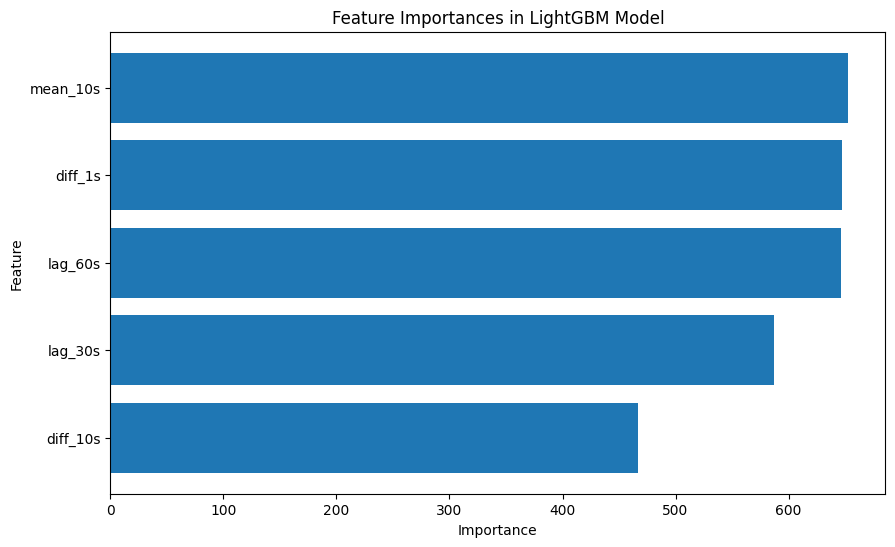

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor

# Após treinar o modelo (como no código que você mostrou)
model = LGBMRegressor(num_leaves=31, min_data_in_leaf=20, subsample=0.8, colsample_bytree=0.8, random_state=None, verbose=-1)
model.fit(X_train, y_train)

# Extrair as importâncias das variáveis
feature_importances = model.feature_importances_
feature_names = X.columns

# Criar um DataFrame para organizar e visualizar as importâncias
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Exibir as importâncias
print(importance_df)

# Plotar as importâncias
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances in LightGBM Model')
plt.gca().invert_yaxis()
plt.show()

In [16]:
# Normalizar as importâncias para que somem 100%
importance_df['Normalized Importance'] = (importance_df['Importance'] / importance_df['Importance'].sum()) * 100
print(importance_df[['Feature', 'Normalized Importance']])

    Feature  Normalized Importance
0  mean_10s              21.766667
1   diff_1s              21.566667
3   lag_60s              21.533333
4   lag_30s              19.566667
2  diff_10s              15.566667


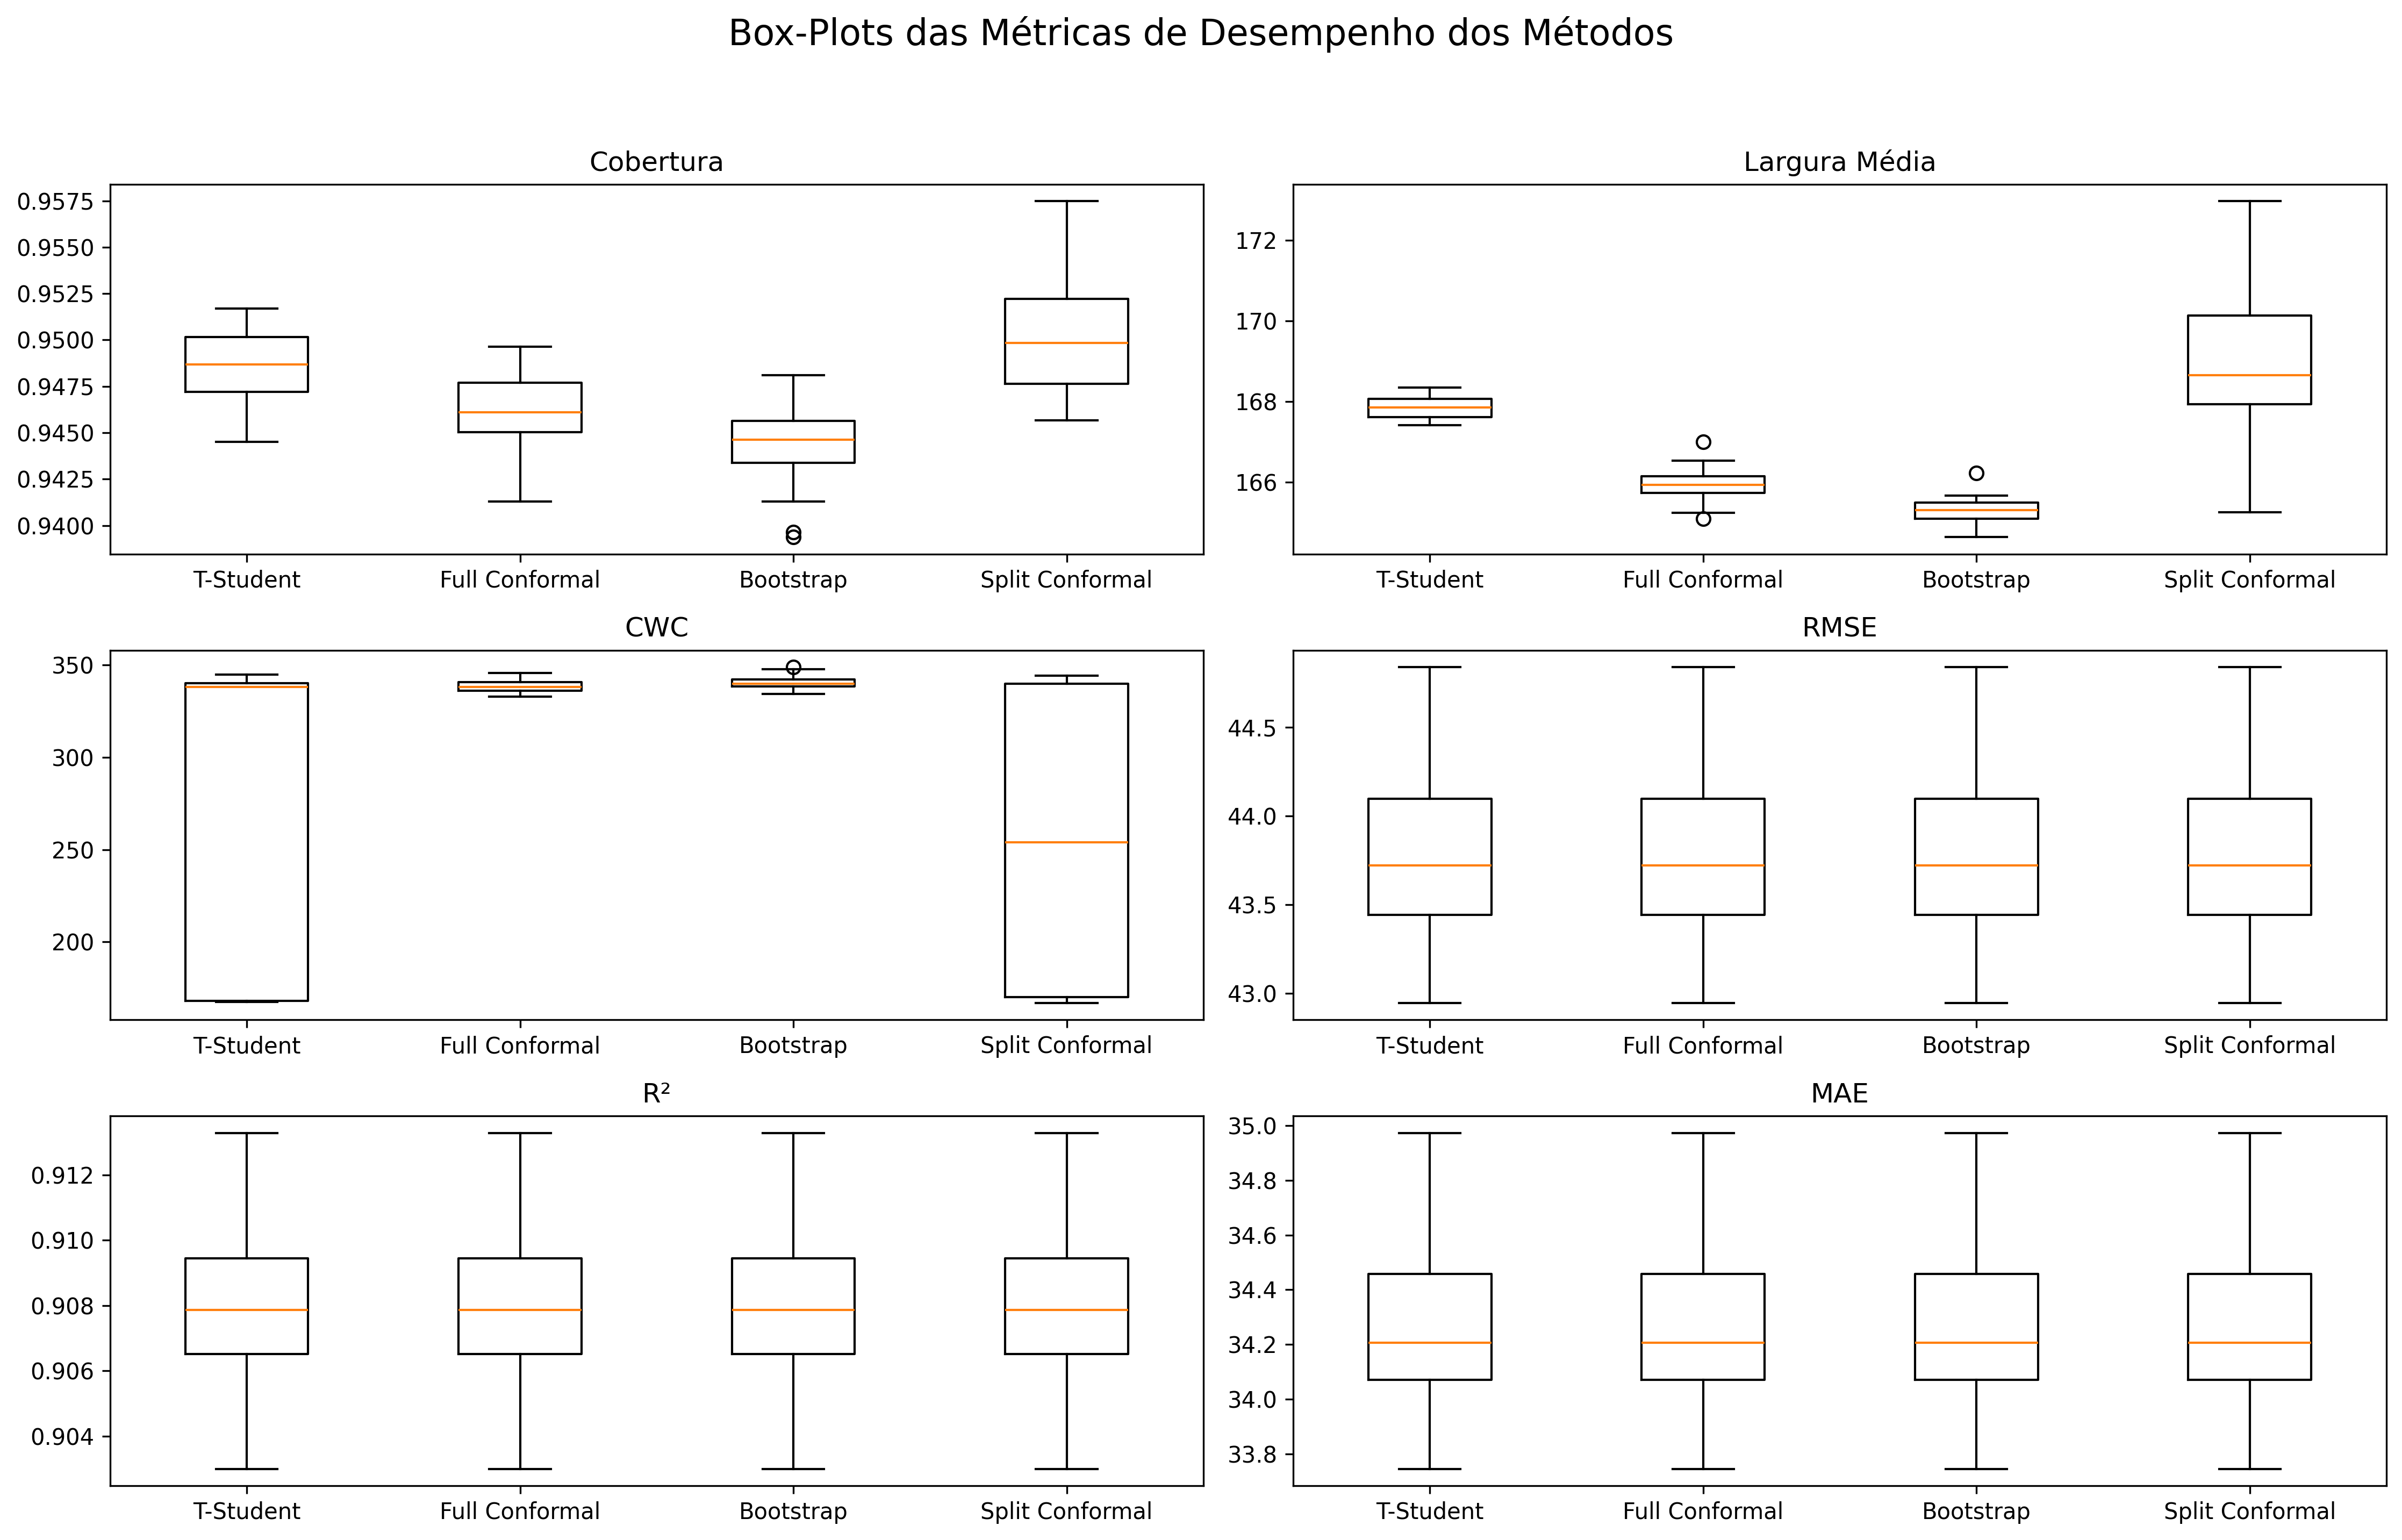

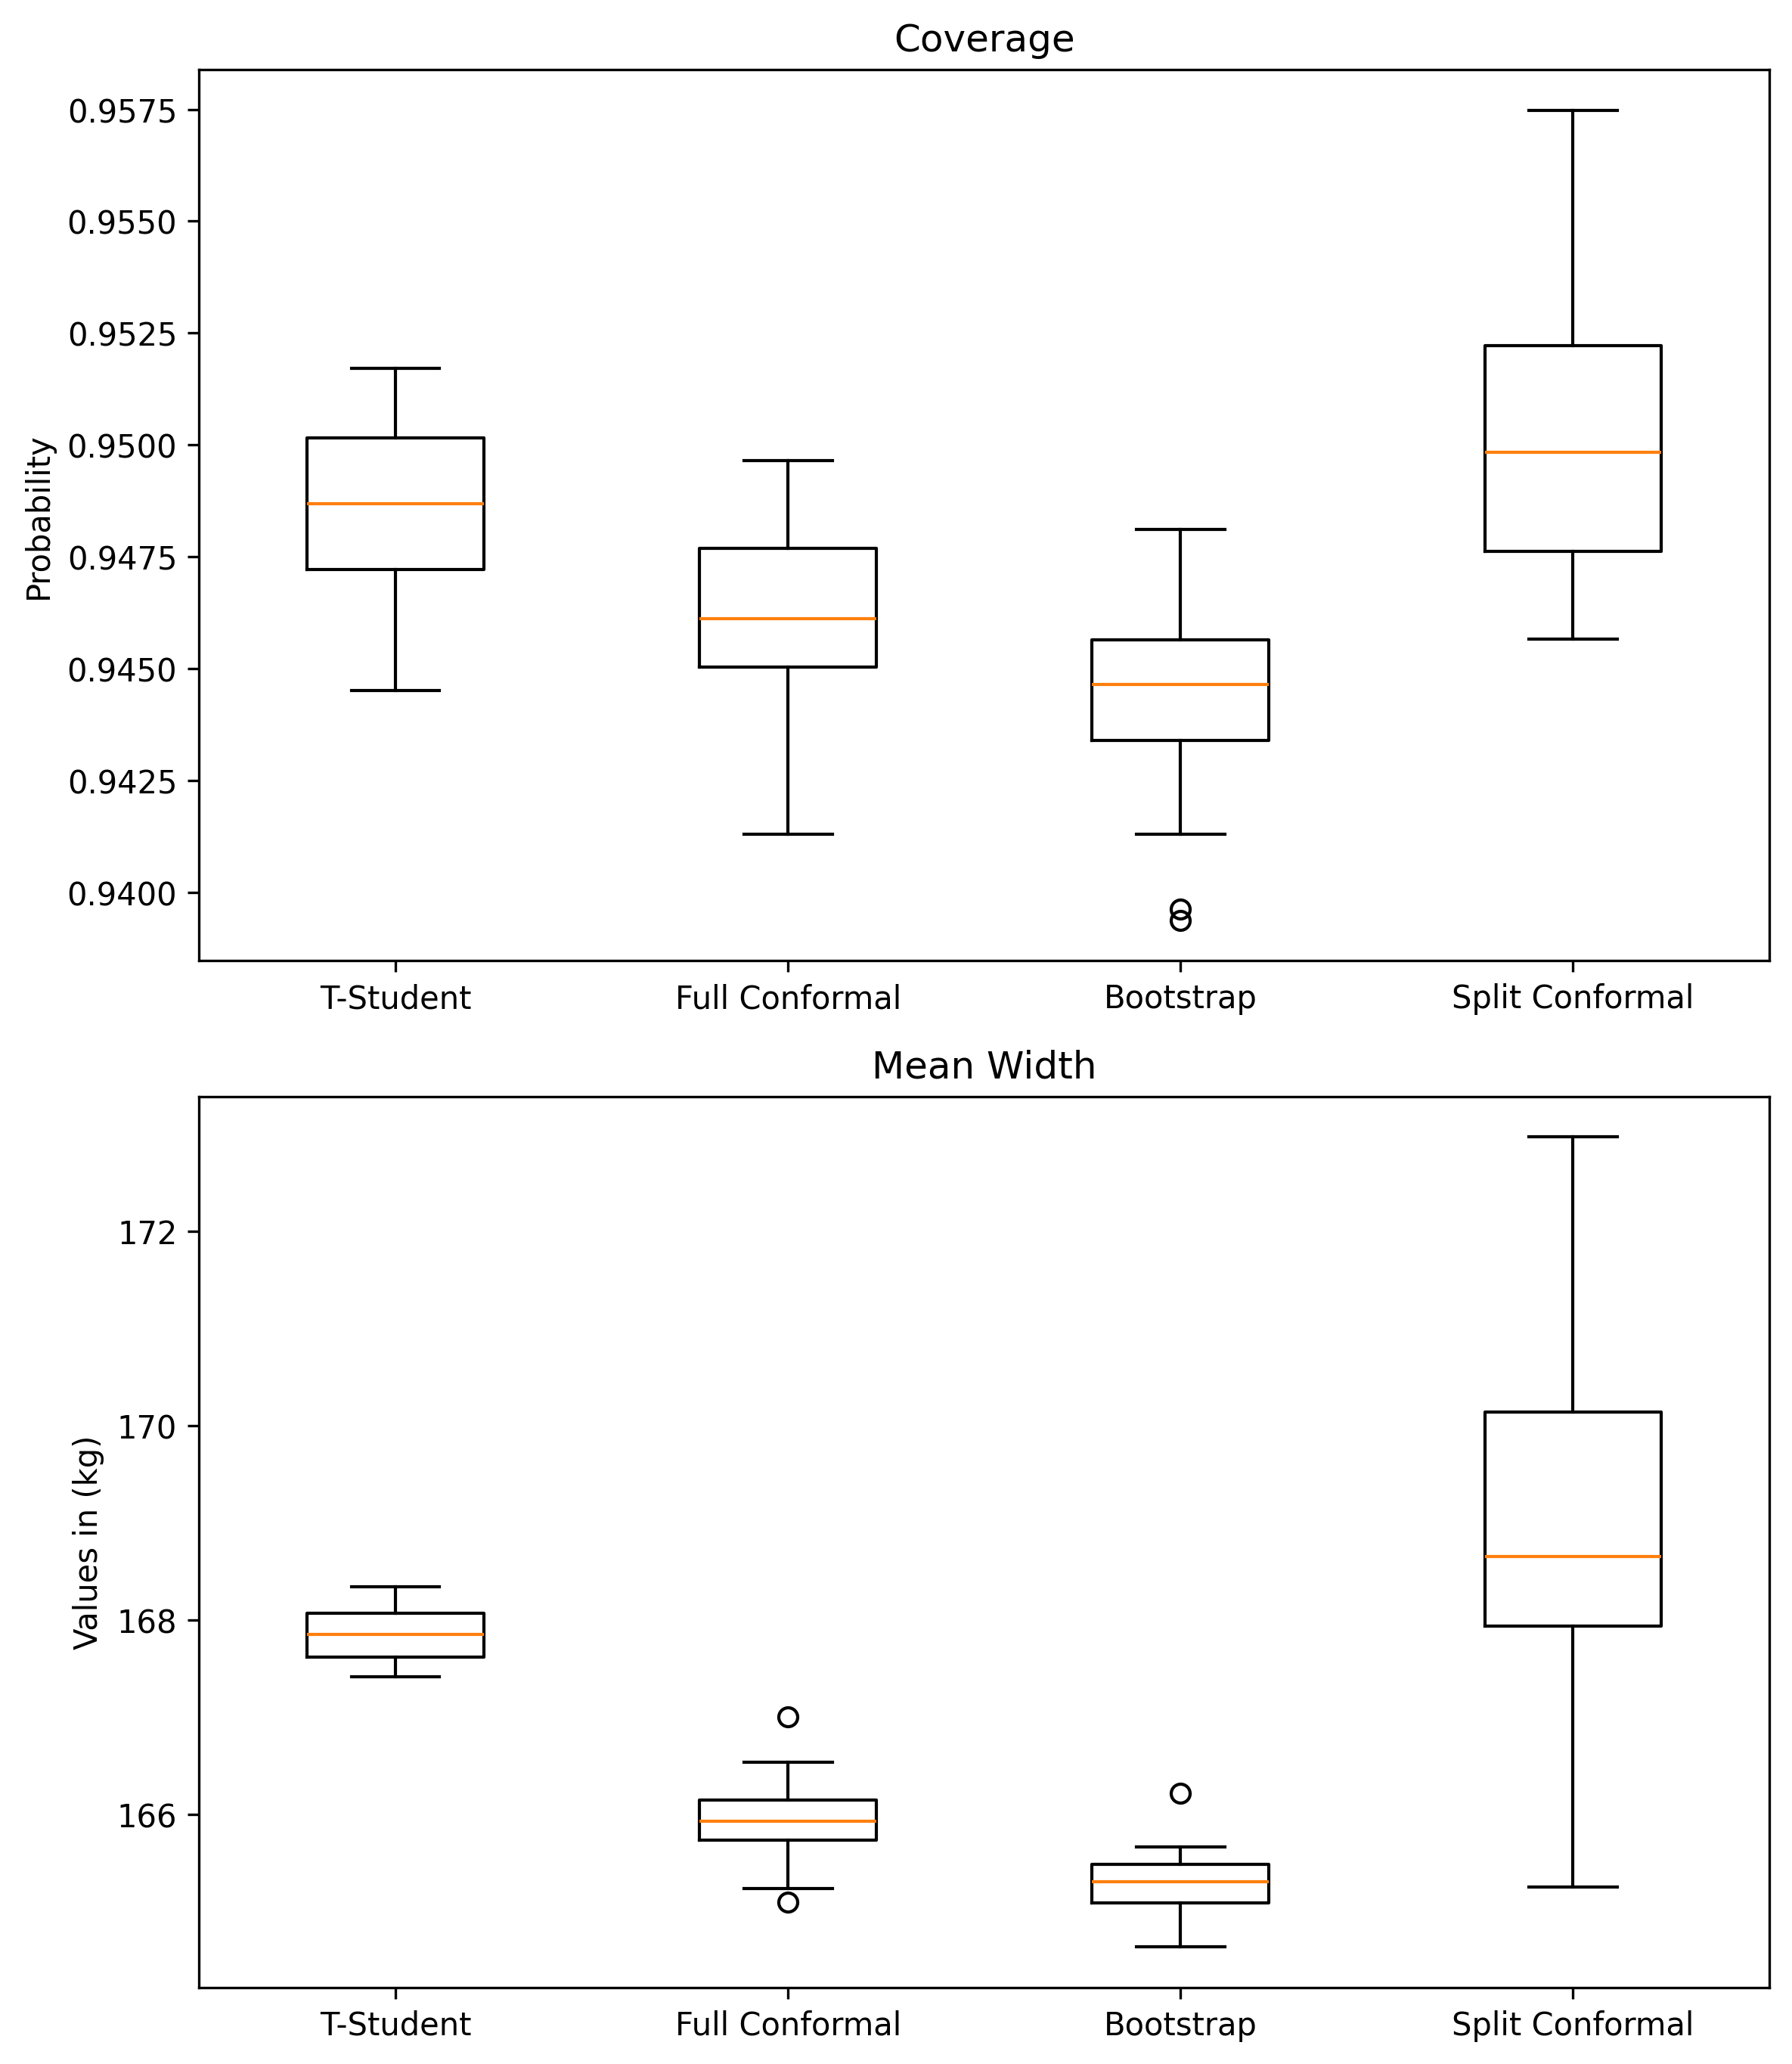

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.utils import resample
from lightgbm import LGBMRegressor
from scipy import stats

# Funções de cálculo de intervalos de predição e métricas de avaliação

def calculate_prediction_intervals(y_pred, residuals, n, p, alpha=0.05):
    s_err = np.std(residuals, ddof=1)  # Erro padrão dos resíduos
    dof = n - p
    t_value = stats.t.ppf(1 - alpha/2, dof)
    margin_of_error = t_value * s_err * np.sqrt(1 + 1/n)
    lower_bound = y_pred - margin_of_error
    upper_bound = y_pred + margin_of_error
    return lower_bound, upper_bound

# Estimativa Intervalar com Full Conformal Prediction
def full_conformal_prediction_intervals(model, X_train, X_test, y_train, alpha=0.05):
    """
    Função para calcular intervalos de predição usando Full Conformal Prediction,
    implementando a fórmula correta para o cálculo do quantil.

    Parâmetros:
    - model: O modelo a ser treinado.
    - X_train: Conjunto de treinamento (features).
    - X_test: Conjunto de teste (features).
    - y_train: Valores alvo do conjunto de treinamento.
    - alpha: Nível de significância (0.05 para intervalo de confiança de 95%).

    Retorna:
    - lower_bound: Limite inferior dos intervalos de predição para o conjunto de teste.
    - upper_bound: Limite superior dos intervalos de predição para o conjunto de teste.
    - quantile: O quantil usado para os cálculos.
    """
    # Treinar o modelo no conjunto de treino
    model.fit(X_train, y_train)

    # Fazer predições no conjunto de treino
    y_pred_train = model.predict(X_train)

    # Calcular os resíduos (erros absolutos) no conjunto de treino
    residuals_train = np.abs(y_train - y_pred_train)

    # Calcular o quantil correto com base em ((n + 1) * (1 - alpha))/n
    n = len(X_train)
    q_quantile = (n + 1) * (1 - alpha) / n  # Fórmula correta para o quantil

    # Calcular o quantil dos resíduos de treino
    quantile = np.quantile(residuals_train, q_quantile)

    # Fazer predições no conjunto de teste
    y_pred_test = model.predict(X_test)

    # Calcular os intervalos de predição para o conjunto de teste
    lower_bound = y_pred_test - quantile
    upper_bound = y_pred_test + quantile

    return lower_bound, upper_bound, quantile
'''
# Função para calcular intervalos de predição usando bootstrap
def bootstrap_prediction_intervals(model, X_test, y_test, n_bootstrap=1000, alpha=0.05):
    # Número de observações no conjunto de teste
    n_obs = len(X_test)

    # Array para armazenar as previsões bootstrap
    bootstrap_predictions = np.zeros((n_bootstrap, n_obs))

    # Resíduos do modelo original
    residuals = y_test - model.predict(X_test)

    # Bootstrap dos resíduos e cálculo das previsões bootstrap
    for i in range(n_bootstrap):
        # Amostragem com reposição dos resíduos
        bootstrap_residuals = resample(residuals)

        # Previsões bootstrap
        bootstrap_predictions[i, :] = model.predict(X_test) + bootstrap_residuals

    # Cálculo dos intervalos de predição
    lower_bound = np.percentile(bootstrap_predictions, 100 * alpha / 2, axis=0)
    upper_bound = np.percentile(bootstrap_predictions, 100 * (1 - alpha / 2), axis=0)

    return lower_bound, upper_bound
'''
# Estimativa Intervalar com Bootstrap
def bootstrap_prediction_intervals(model, X_train, y_train, X_test, n_bootstrap=1000, alpha=0.05):
    # Fazer previsões no conjunto de teste
    y_pred_test = model.predict(X_test)

    # Calcular os resíduos com base nas previsões do conjunto de treino
    residuals = y_train - model.predict(X_train)

    # Inicializar a matriz de predições bootstrap
    n_obs = len(X_test)
    bootstrap_predictions = np.zeros((n_bootstrap, n_obs))

    # Gerar as predições bootstrap
    for i in range(n_bootstrap):
        # Amostrar com substituição dos resíduos de treinamento, ajustando o tamanho
        bootstrap_residuals = resample(residuals, n_samples=n_obs, replace=True)

        # Adicionar os resíduos bootstrap às previsões do conjunto de teste
        bootstrap_predictions[i, :] = y_pred_test + bootstrap_residuals

    # Calcular os intervalos percentuais
    lower_bound = np.percentile(bootstrap_predictions, 100 * alpha / 2, axis=0)
    upper_bound = np.percentile(bootstrap_predictions, 100 * (1 - alpha / 2), axis=0)

    return lower_bound, upper_bound

# Função para calcular intervalos de predição conforme dividido (split conformal prediction)
def conformal_prediction_intervals(model, X_train, y_train, X_cal, y_cal, X_test, alpha=0.05):
    model.fit(X_train, y_train)
    y_pred_cal = model.predict(X_cal)
    # Residuals
    y_cal_error = np.abs(y_cal - y_pred_cal)
    # Calcular o quantil com ajuste da amostra final para garantir a cobertura
    n_cal = len(y_cal)
    q_quantile = (n_cal + 1) * (1 - alpha) / n_cal
    # Calcular q_hat no conjunto de calibração
    quantile = np.quantile(y_cal_error, q_quantile)
    y_pred_test = model.predict(X_test)
    return y_pred_test - quantile, y_pred_test + quantile


def calculate_interval_metrics(y_true, y_pred, lower_bound, upper_bound, alpha=0.05):
    coverage_score = np.mean((y_true >= lower_bound) & (y_true <= upper_bound))
    mean_width_score = np.mean(upper_bound - lower_bound)
    eta = 10
    gamma = 0 if coverage_score >= (1 - alpha) else 1
    cwc = mean_width_score * (1 + gamma * np.exp(-eta * (coverage_score - (1 - alpha))))
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    return coverage_score, mean_width_score, cwc, rmse, r2, mae

# Inicializar listas para armazenar resultados de 30 iterações
metrics_results = {
    'T-Student': {'Coverage': [], 'Mean Width': [], 'CWC': [], 'RMSE': [], 'R2': [], 'MAE':[]},
    'Full Conformal': {'Coverage': [], 'Mean Width': [], 'CWC': [], 'RMSE': [], 'R2': [], 'MAE':[]},
    'Bootstrap': {'Coverage': [], 'Mean Width': [], 'CWC': [], 'RMSE': [], 'R2': [], 'MAE':[]},
    'Split Conformal': {'Coverage': [], 'Mean Width': [], 'CWC': [], 'RMSE': [], 'R2': [], 'MAE':[]}
}

# Definir variáveis de entrada (exemplo com dados fictícios; substitua por seus dados)
X = data[['mean_10s', 'diff_1s', 'diff_10s', 'lag_60s', 'lag_30s']]
y = data['bal75_next_1']

from sklearn.model_selection import train_test_split

# Definir proporções para divisão dos dados
train_ratio = 0.8
cal_ratio = 0.1
test_ratio = 0.1

# Realizar 30 iterações para coletar as métricas
for _ in range(30):
    # Dividir em conjunto de treino e conjunto auxiliar (que será dividido em calibração e teste)
    X_train, X_aux, y_train, y_aux = train_test_split(X, y, test_size=(1 - train_ratio), random_state=None)
    
    # Dividir o conjunto auxiliar em calibração e teste
    X_cal, X_test, y_cal, y_test = train_test_split(X_aux, y_aux, test_size=test_ratio/(test_ratio + cal_ratio), random_state=None)
    
    # Treinar o modelo
    model = LGBMRegressor(num_leaves=31, min_data_in_leaf=20, subsample=0.8, colsample_bytree=0.8, random_state=None, verbose=-1)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    residuals = y_train - model.predict(X_train)

    # Cálculo dos intervalos e métricas de cada método (T-Student, Full Conformal, Bootstrap, Split Conformal)
    # T-Student
    lower_bound, upper_bound = calculate_prediction_intervals(y_pred, residuals, len(X_train), X_train.shape[1])
    coverage, mean_width, cwc, rmse, r2, mae = calculate_interval_metrics(y_test, y_pred, lower_bound, upper_bound)
    for metric_name, metric_value in zip(['Coverage', 'Mean Width', 'CWC', 'RMSE', 'R2', 'MAE'],
                                         [coverage, mean_width, cwc, rmse, r2, mae]):
        metrics_results['T-Student'][metric_name].append(metric_value)

    # Full Conformal
    lower_bound, upper_bound, _ = full_conformal_prediction_intervals(model, X_train, X_test, y_train)
    coverage, mean_width, cwc, rmse, r2, mae = calculate_interval_metrics(y_test, y_pred, lower_bound, upper_bound)
    for metric_name, metric_value in zip(['Coverage', 'Mean Width', 'CWC', 'RMSE', 'R2', 'MAE'],
                                         [coverage, mean_width, cwc, rmse, r2, mae]):
        metrics_results['Full Conformal'][metric_name].append(metric_value)

    # Bootstrap
    lower_bound, upper_bound = bootstrap_prediction_intervals(model, X_train, y_train, X_test)
    coverage, mean_width, cwc, rmse, r2, mae = calculate_interval_metrics(y_test, y_pred, lower_bound, upper_bound)
    for metric_name, metric_value in zip(['Coverage', 'Mean Width', 'CWC', 'RMSE', 'R2', 'MAE'],
                                         [coverage, mean_width, cwc, rmse, r2, mae]):
        metrics_results['Bootstrap'][metric_name].append(metric_value)

    # Split Conformal
    lower_bound, upper_bound = conformal_prediction_intervals(model, X_train, y_train, X_cal, y_cal, X_test)
    coverage, mean_width, cwc, rmse, r2, mae = calculate_interval_metrics(y_test, y_pred, lower_bound, upper_bound)
    for metric_name, metric_value in zip(['Coverage', 'Mean Width', 'CWC', 'RMSE', 'R2', 'MAE'],
                                         [coverage, mean_width, cwc, rmse, r2, mae]):
        metrics_results['Split Conformal'][metric_name].append(metric_value)

'''
# Realizar 30 iterações para coletar as métricas
for _ in range(30):
    X_train, X_cal, X_test = X[:n_train], X[n_train:n_train+n_cal], X[n_train+n_cal:]
    y_train, y_cal, y_test = y[:n_train], y[n_train:n_train+n_cal], y[n_train+n_cal:]

    #model = LGBMRegressor(random_state=None)
    model = LGBMRegressor(num_leaves=31, min_data_in_leaf=20, subsample=0.8, colsample_bytree=0.8, random_state=None, verbose=-1)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    residuals = y_train - model.predict(X_train)

    # T-Student
    lower_bound, upper_bound = calculate_prediction_intervals(y_pred, residuals, len(X_train), X_train.shape[1])
    coverage, mean_width, cwc, rmse, r2, mae = calculate_interval_metrics(y_test, y_pred, lower_bound, upper_bound)
    metrics_results['T-Student']['Coverage'].append(coverage)
    metrics_results['T-Student']['Mean Width'].append(mean_width)
    metrics_results['T-Student']['CWC'].append(cwc)
    metrics_results['T-Student']['RMSE'].append(rmse)
    metrics_results['T-Student']['R2'].append(r2)
    metrics_results['T-Student']['MAE'].append(mae)

    # Full Conformal
    lower_bound, upper_bound, _ = full_conformal_prediction_intervals(model, X_train, X_test, y_train)
    coverage, mean_width, cwc, rmse, r2, mae = calculate_interval_metrics(y_test, y_pred, lower_bound, upper_bound)
    metrics_results['Full Conformal']['Coverage'].append(coverage)
    metrics_results['Full Conformal']['Mean Width'].append(mean_width)
    metrics_results['Full Conformal']['CWC'].append(cwc)
    metrics_results['Full Conformal']['RMSE'].append(rmse)
    metrics_results['Full Conformal']['R2'].append(r2)
    metrics_results['Full Conformal']['MAE'].append(mae)

    # Bootstrap
    lower_bound, upper_bound = bootstrap_prediction_intervals(model, X_train, y_train, X_test)
    coverage, mean_width, cwc, rmse, r2, mae = calculate_interval_metrics(y_test, y_pred, lower_bound, upper_bound)
    metrics_results['Bootstrap']['Coverage'].append(coverage)
    metrics_results['Bootstrap']['Mean Width'].append(mean_width)
    metrics_results['Bootstrap']['CWC'].append(cwc)
    metrics_results['Bootstrap']['RMSE'].append(rmse)
    metrics_results['Bootstrap']['R2'].append(r2)
    metrics_results['Bootstrap']['MAE'].append(mae)

    # Split Conformal
    lower_bound, upper_bound = conformal_prediction_intervals(model, X_train, y_train, X_cal, y_cal, X_test)
    coverage, mean_width, cwc, rmse, r2, mae = calculate_interval_metrics(y_test, y_pred, lower_bound, upper_bound)
    metrics_results['Split Conformal']['Coverage'].append(coverage)
    metrics_results['Split Conformal']['Mean Width'].append(mean_width)
    metrics_results['Split Conformal']['CWC'].append(cwc)
    metrics_results['Split Conformal']['RMSE'].append(rmse)
    metrics_results['Split Conformal']['R2'].append(r2)
    metrics_results['Split Conformal']['MAE'].append(mae)

'''

import matplotlib.pyplot as plt

# Criar a figura com subplots para as 6 métricas
fig, axs = plt.subplots(3, 2, figsize=(15, 10), dpi=300)
fig.suptitle('Box-Plots das Métricas de Desempenho dos Métodos', fontsize=16)

# Dados para cada métrica (substitua pelos seus resultados armazenados em metrics_results)
# Aqui assumo que `metrics_results` é um dicionário onde as chaves são os métodos e os valores são listas de valores para cada métrica
coverage_data = [metrics_results[method]['Coverage'] for method in metrics_results.keys()]
mean_width_data = [metrics_results[method]['Mean Width'] for method in metrics_results.keys()]
cwc_data = [metrics_results[method]['CWC'] for method in metrics_results.keys()]
rmse_data = [metrics_results[method]['RMSE'] for method in metrics_results.keys()]
r2_data = [metrics_results[method]['R2'] for method in metrics_results.keys()]
mae_data = [metrics_results[method]['MAE'] for method in metrics_results.keys()]


# Plotando cada métrica em um subplot
axs[0, 0].boxplot(coverage_data, labels=metrics_results.keys())
axs[0, 0].set_title('Cobertura')

axs[0, 1].boxplot(mean_width_data, labels=metrics_results.keys())
axs[0, 1].set_title('Largura Média')

axs[1, 0].boxplot(cwc_data, labels=metrics_results.keys())
axs[1, 0].set_title('CWC')

axs[1, 1].boxplot(rmse_data, labels=metrics_results.keys())
axs[1, 1].set_title('RMSE')

axs[2, 0].boxplot(r2_data, labels=metrics_results.keys())
axs[2, 0].set_title('R²')

axs[2, 1].boxplot(mae_data, labels=metrics_results.keys())
axs[2, 1].set_title('MAE')

# Ajuste de layout para evitar sobreposição
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

import matplotlib.pyplot as plt

# Criar a figura com subplots para Coverage e Mean Width
fig, axs = plt.subplots(2, 1, figsize=(8, 10), dpi=300)  # 2 linhas, 1 coluna
#fig.suptitle('Coverage and Mean Width Score With Random Selection of Data', fontsize=16)

# Dados para as métricas Coverage e Mean Width (assumindo que metrics_results é um dicionário conforme descrito)
coverage_data = [metrics_results[method]['Coverage'] for method in metrics_results.keys()]
mean_width_data = [metrics_results[method]['Mean Width'] for method in metrics_results.keys()]

# Plotando Coverage no primeiro subplot
axs[0].boxplot(coverage_data, labels=metrics_results.keys())
axs[0].set_title('Coverage')
axs[0].set_ylabel('Probability')

# Plotando Mean Width no segundo subplot
axs[1].boxplot(mean_width_data, labels=metrics_results.keys())
axs[1].set_title('Mean Width')
axs[1].set_ylabel('Values in (kg)')

# Ajuste de layout para evitar sobreposição
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


    Feature  Importance
0  mean_10s         657
1   diff_1s         634
3   lag_60s         618
4   lag_30s         613
2  diff_10s         478


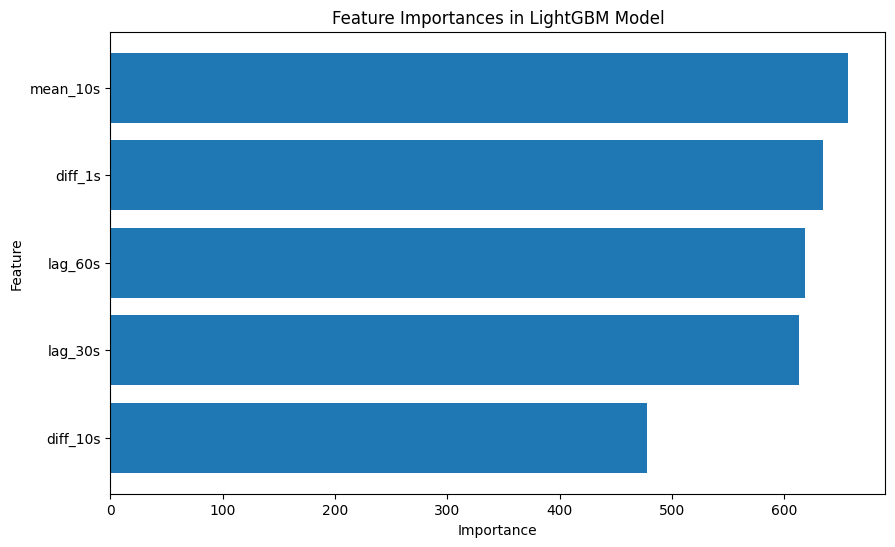

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor

# Após treinar o modelo (como no código que você mostrou)
model = LGBMRegressor(num_leaves=31, min_data_in_leaf=20, subsample=0.8, colsample_bytree=0.8, random_state=None, verbose=-1)
model.fit(X_train, y_train)

# Extrair as importâncias das variáveis
feature_importances = model.feature_importances_
feature_names = X.columns

# Criar um DataFrame para organizar e visualizar as importâncias
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Exibir as importâncias
print(importance_df)

# Plotar as importâncias
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances in LightGBM Model')
plt.gca().invert_yaxis()
plt.show()

In [19]:
# Normalizar as importâncias para que somem 100%
importance_df['Normalized Importance'] = (importance_df['Importance'] / importance_df['Importance'].sum()) * 100
print(importance_df[['Feature', 'Normalized Importance']])

    Feature  Normalized Importance
0  mean_10s              21.900000
1   diff_1s              21.133333
3   lag_60s              20.600000
4   lag_30s              20.433333
2  diff_10s              15.933333


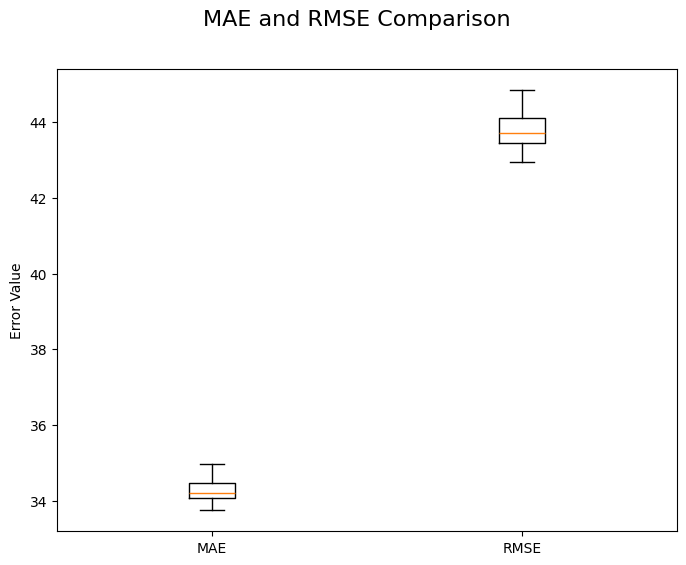

In [25]:
import matplotlib.pyplot as plt

# Extraindo os dados de MAE e RMSE
mae_data = metrics_results['Full Conformal']['MAE']
rmse_data = metrics_results['Full Conformal']['RMSE']

# Criar a figura para o box-plot com as duas métricas
fig, ax = plt.subplots(figsize=(8, 6))
fig.suptitle('MAE and RMSE Comparison', fontsize=16)

# Plotando MAE e RMSE no mesmo gráfico de box-plot
ax.boxplot([mae_data, rmse_data], labels=['MAE', 'RMSE'])
ax.set_ylabel('Error Value')

# Exibir o gráfico
plt.show()

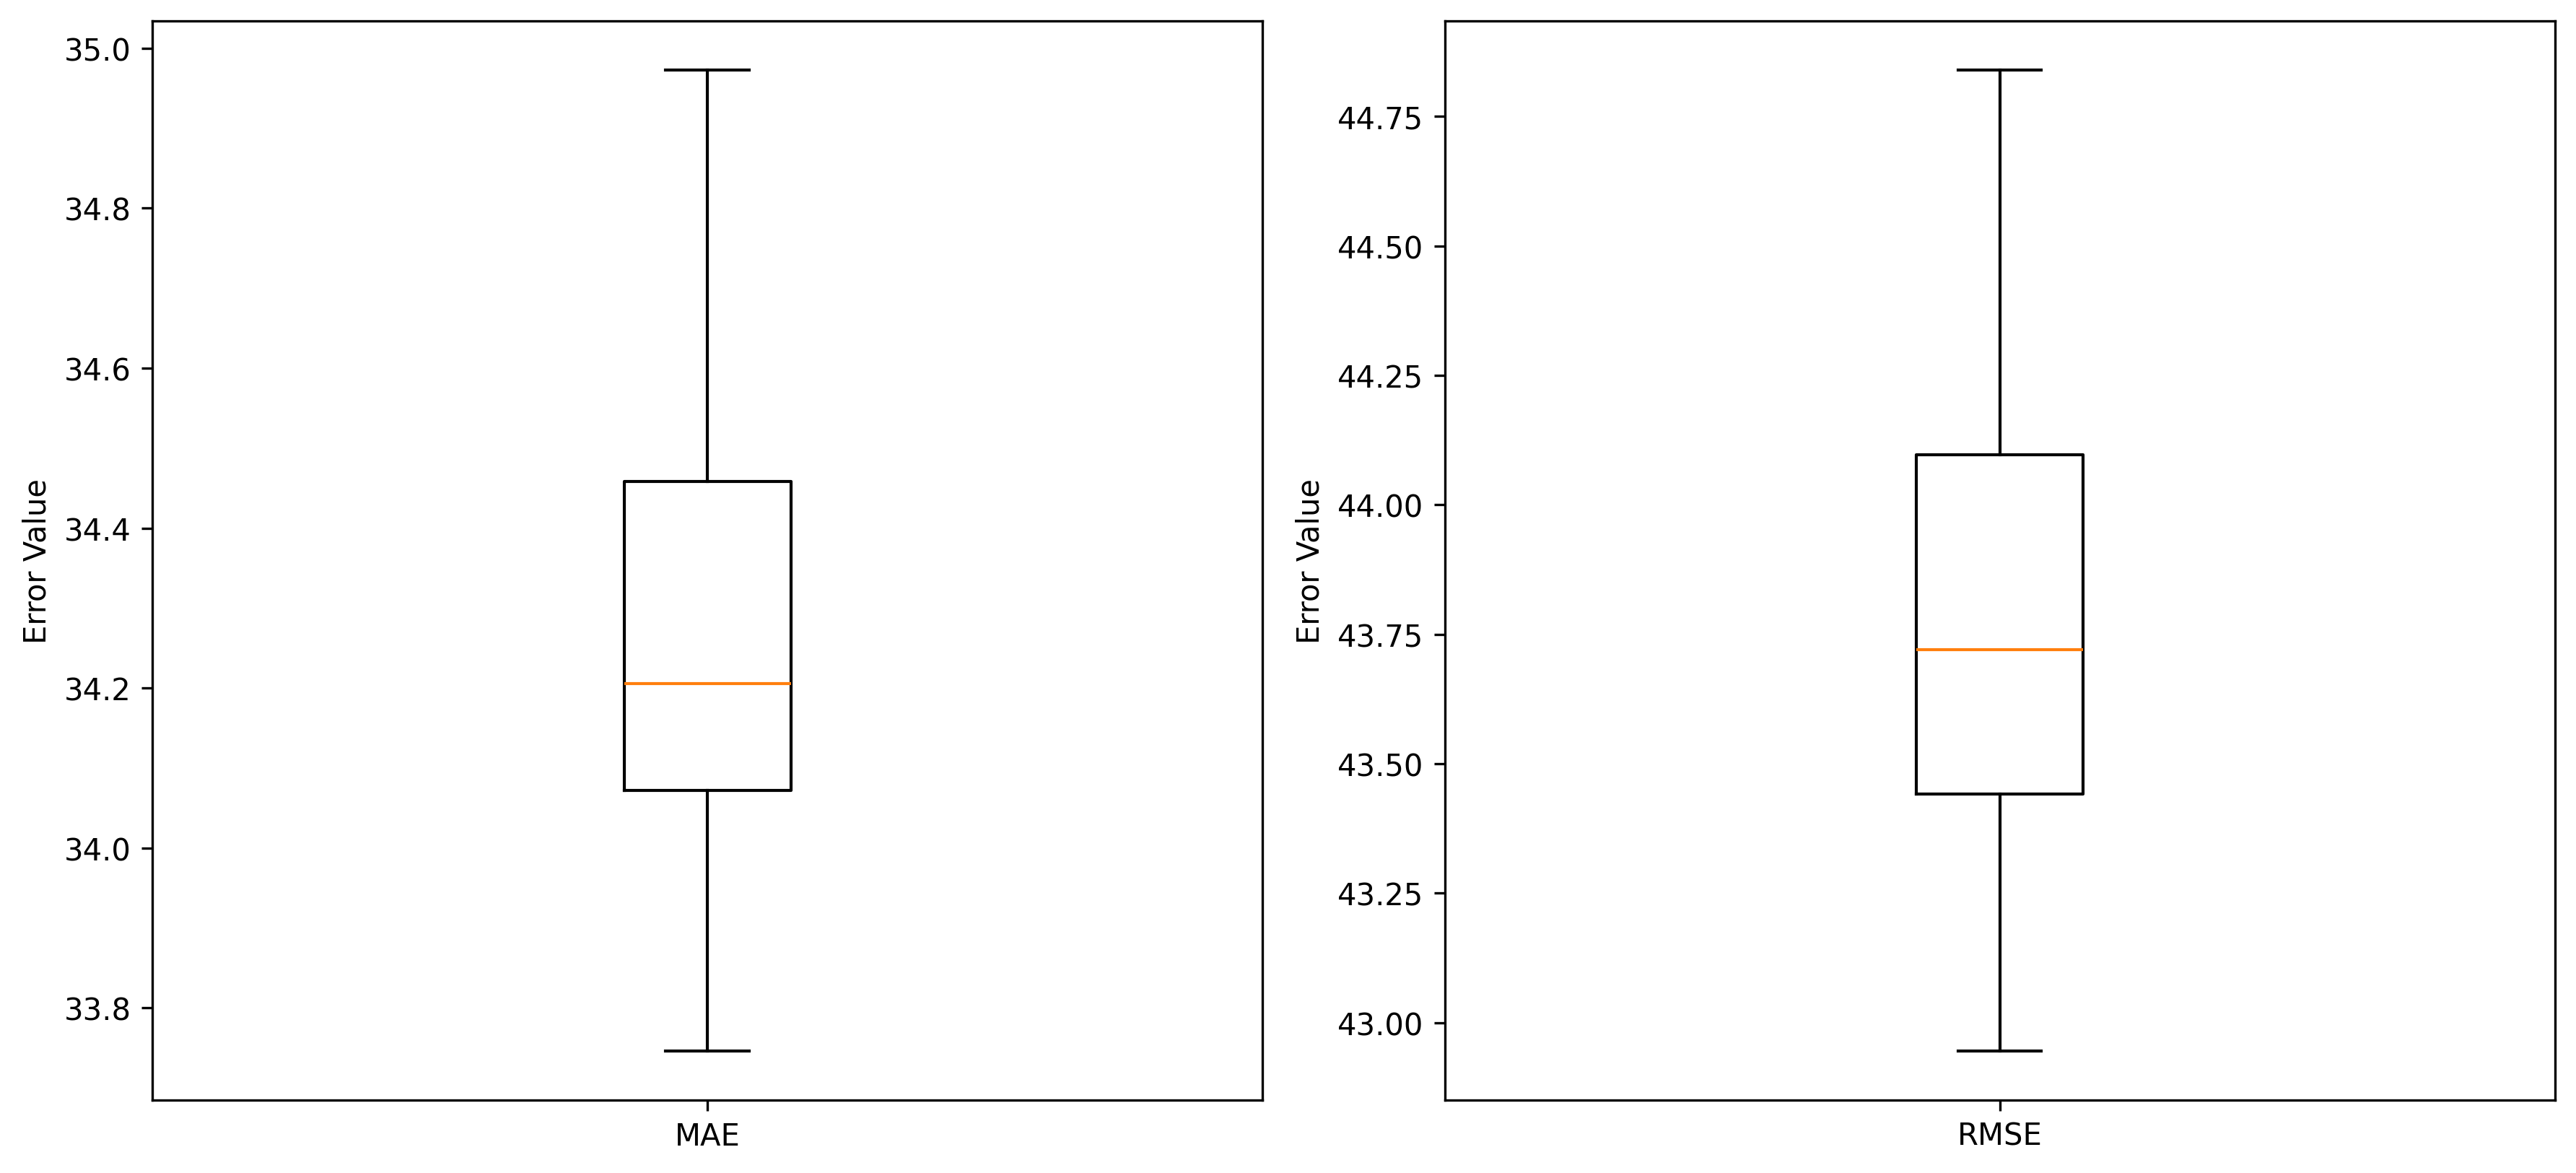

In [24]:
# Extraindo os dados de MAE e RMSE
mae_data = metrics_results['Full Conformal']['MAE']
rmse_data = metrics_results['Full Conformal']['RMSE']

# Criar a figura com subplots para MAE e RMSE, lado a lado
fig, axs = plt.subplots(1, 2, figsize=(12, 6), dpi=300)  # 1 linha, 2 colunas
#fig.suptitle('MAE and RMSE Comparison for Prediction Interval Method', fontsize=16)

# Plotando MAE no primeiro subplot
axs[0].boxplot(mae_data, labels=['MAE'])
#axs[0].set_title('Mean Absolute Error (MAE)')
axs[0].set_ylabel('Error Value')

# Plotando RMSE no segundo subplot
axs[1].boxplot(rmse_data, labels=['RMSE'])
#axs[1].set_title('Root Mean Squared Error (RMSE)')
axs[1].set_ylabel('Error Value')

# Ajuste de layout para evitar sobreposição
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()